# Импортирование необходимых библиотек

In [1]:
import os
import uuid
import tarfile
import numpy as np
import urllib.request
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report

import onnx
import pickle

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torchvision.models as models

In [2]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Device name: NVIDIA GeForce GTX 1650 Ti
CUDA capability: (7, 5)
Driver version: 12.1
Device count: 1
Current device: 0


# Загрузка и распаковка набора данных CIFAR100

In [3]:
def download_and_extract_cifar100(
    filename="cifar-100-python.tar.gz", 
    url="https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz", 
    extract_dir="cifar-100-python"
    ):
    """
    Функция для скачивания и распаковки архива CIFAR-100.
    
    Args:
        filename (str): Имя архива, который нужно скачать.
        url (str): URL для скачивания архива.
        extract_dir (str): Папка, куда нужно распаковать архив.
    """
    
    # Проверяем наличие файла
    if not os.path.exists(filename):
        # Файла нет, скачиваем
        print(f"Скачивание {filename}...")
        urllib.request.urlretrieve(url, filename)
        print(f"Файл '{filename}' был успешно скачан.")
    else:
        print(f"Файл '{filename}' уже существует.")

    # Проверяем, был ли архив распакован
    if not os.path.exists(extract_dir):
        print(f"Распаковка {filename}...")
        with tarfile.open(filename, "r:gz") as tar:
            tar.extractall()
        print(f"Архив распакован в папку '{extract_dir}'.")
    else:
        print("Архив уже распакован.")
        
download_and_extract_cifar100()

Файл 'cifar-100-python.tar.gz' уже существует.
Архив уже распакован.


## Архитектуры модели

### Класс модели CIFAR100

In [4]:
class CIFAR100Trainer:
    def __init__(self, classes, batch_size=128, lr_rate=1e-4, criterion=nn.CrossEntropyLoss()):
        self.classes = classes
        self.batch_size = batch_size
        self.lr_rate = lr_rate
        self.device = self.check_device()
        self.criterion = criterion
        self.history = {"epoch": [], "loss": []}  # История обучения
        # Загрузка названий классов
        self.class_names = self.load_class_names()
        
        # Чтение тренировочной выборки (обучающих данных)
        with open('cifar-100-python/train', 'rb') as f:
            data_train = pickle.load(f, encoding='latin1')

        # Чтение тестовой выборки (тестовых данных)
        with open('cifar-100-python/test', 'rb') as f:
            data_test = pickle.load(f, encoding='latin1')

        # Фильтрация данных и создание датасетов
        self.train_dataset = self.prepare_data(data_train, 'train')
        self.test_dataset = self.prepare_data(data_test, 'test')

        # Загрузка данных в батчи
        self.train_loader = DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
        
    def load_class_names(self):
        """Загружает названия классов из мета-файла."""
        with open('cifar-100-python/meta', 'rb') as f:
            meta = pickle.load(f, encoding='latin1')
        return meta['fine_label_names']

    def prepare_data(self, data, part):
        """Фильтрация данных и преобразование в TensorDataset."""
        X = data['data'].reshape(-1, 3, 32, 32)  # Данные в формате NCHW
        X = np.transpose(X, [0, 2, 3, 1]) # NCHW -> NHWC
        y = np.array(data['fine_labels'])

        mask = np.isin(y, self.classes)
        X = X[mask].copy()
        y = y[mask].copy()
        y = np.unique(y, return_inverse=1)[1]

        tensor_x = torch.Tensor(X)
        tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64), num_classes=len(self.classes)) / 1.
        dataset = TensorDataset(tensor_x, tensor_y)
        return dataset
        
    def train(self, model, epochs=10):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=self.lr_rate)
        self.history = {"epoch": [], "loss": []}  # Инициализация истории

        for epoch in range(epochs):
            model.train()  # Установка модели в режим обучения
            running_loss = 0.0

            progress_bar = tqdm(self.train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit="batch")
            for batch_idx, (data, target) in enumerate(progress_bar):
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                # Вызов метода forward() модели
                output = model.forward(data) 
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                progress_bar.set_postfix(loss=f"{loss:.6f}")
                
            average_loss = running_loss / len(self.train_loader)
            self.history["epoch"].append(epoch + 1)
            self.history["loss"].append(average_loss)  # Сохранение средней потери

            print(f'Epoch: {epoch+1}/{epochs}, Loss: {running_loss/len(self.train_loader):.6f}')

    def evaluate(self, model):
        model = model.to(self.device)
        model.eval()  # Установка модели в режим оценки
        
        # Обрабатываем обе выборки: тренировочную и тестовую
        dataloaders = {'train': self.train_loader, 'test': self.test_loader}
        
        for part in ['train', 'test']:
            all_predicted = []
            all_target = []
            with torch.no_grad():
                for data, target in dataloaders[part]:
                    data, target = data.to(self.device), target.to(self.device)
                    output = model(data)
                    
                    # Получаем предсказания
                    _, predicted = torch.max(output.data, 1)
                    
                    # Преобразуем target обратно в одномерный тензор
                    target_indices = torch.argmax(target, dim=1)
                    
                    all_predicted.extend(predicted.cpu().numpy())
                    all_target.extend(target_indices.cpu().numpy())
            
            # Преобразуем списки в массивы NumPy
            all_predicted = np.array(all_predicted)
            all_target = np.array(all_target)
            
            # Выводим наименования классов для выбранных индексов
            selected_class_names = [self.class_names[i] for i in self.classes]
            
            # Выводим отчет о классификации
            print(f"Classification report for {part} dataset:")
            report = classification_report(all_target, all_predicted, target_names=selected_class_names, zero_division=0, digits=4)
            print(report)
            print('-' * 50)

    def save_model(self, model, path='models/'):
        # Генерируем уникальный идентификатор
        unique_id = str(uuid.uuid4())  # Генерация уникального ID
        model_name = f"cifar100_{unique_id}.onnx"  # Формируем название модели
        
        # Создаем полный путь для сохранения модели
        filepath = os.path.join(path, model_name)  # Корректное соединение пути и имени файла
        
        # Убедимся, что директория для сохранения существует
        os.makedirs(path, exist_ok=True)  # Создаем директорию, если она не существует

        # Входной тензор для модели (с учетом правильного порядка: (N, H, W, C))
        dummy_input = torch.randn(1, 32, 32, 3, requires_grad=True).to(self.device)  # (N, H, W, C)
    
        # Экспорт модели
        torch.onnx.export(
            model,               # модель
            dummy_input,         # входной тензор
            filepath,            # куда сохранить
            export_params=True,  # сохраняет веса обученных параметров внутри файла модели
            opset_version=9,    # версия ONNX
            do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
            input_names=['input'],    # имя входного слоя
            output_names=['output'],   # имя выходного слоя
            dynamic_axes={'input': {0: 'batch_size'},    # динамичные оси
                          'output': {0: 'batch_size'}}
        )
        
        # Вывод информации о сохраненной модели
        print(f"Model saved as: {model_name}")
        print(f"Model UUID: {unique_id}")

    def check_device(self):
        """Проверяет доступность CUDA и возвращает устройство."""
        if torch.cuda.is_available():
            device = 'cuda'
        else:
            device = 'cpu'
        print(f'Используемое устройство: {device}')
        return device

    def plot_training_history(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
    
        # Первый график: Полная история
        axs[0].plot(epochs, self.history["loss"], marker='o', linestyle='-', color='b', markersize=5, label='Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()
    
        # Второй график: Половина истории
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], self.history["loss"][mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average Loss')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

    def load_class_names(self):
        """Загружает названия классов из мета-файла."""
        with open('cifar-100-python/meta', 'rb') as f:
            meta = pickle.load(f, encoding='latin1')
        return meta['fine_label_names']
    
    def display_images_with_predictions(self, model, image_dir='./images'):
        """Отображает изображения и предсказания модели с процентным соотношением для заданных классов."""
        # Определение преобразований для входных изображений
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Пример нормализации, может потребоваться адаптация
        ])
    
        # Создаем отображение названий классов для выбранных индексов
        selected_class_names = [self.class_names[i] for i in self.classes]
    
        # Получаем список изображений
        images = [img for img in os.listdir(image_dir) if img.endswith(('jpg', 'png', 'jpeg'))]
        predictions = []
        probabilities = []
    
        for img_name in images:
            img_path = os.path.join(image_dir, img_name)
            img = Image.open(img_path).convert('RGB')  # Открываем изображение
            img_tensor = transform(img).unsqueeze(0).to(self.device)  # Применяем преобразования и добавляем размерность батча
            
            # Получаем предсказание модели
            with torch.no_grad():
                output = model(img_tensor)
                probs = torch.softmax(output, dim=1)  # Вычисляем вероятности
                predicted = torch.argmax(probs).item()  # Предсказанный класс
                predictions.append(predicted)  # Сохраняем предсказание
                probabilities.append(probs.squeeze().cpu().numpy())  # Сохраняем вероятности
    
        # Визуализация
        num_images = len(images)
        cols = 3
        rows = (num_images + cols - 1) // cols  # Вычисляем количество строк
        
        fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))
        axs = axs.flatten()  # Упрощаем доступ к осям
    
        for i, img_name in enumerate(images):
            img_path = os.path.join(image_dir, img_name)
            img = Image.open(img_path)
            axs[i].imshow(img)
            
            # Выводим предсказания и вероятности для выбранных классов
            title_text = f'Predicted: {self.class_names[predictions[i]]} (ID: {predictions[i]})\n'
            for cls in self.classes:
                # Получаем индекс и название класса
                if cls < len(probabilities[i]):
                    title_text += f'{selected_class_names[self.classes.index(cls)]}: {probabilities[i][cls] * 100:.2f}%, '
    
            axs[i].set_title(title_text[:-2])  # Убираем последний запятую
            axs[i].axis('off')  # Скрываем оси
    
        # Удаляем пустые оси, если их больше чем изображений
        for j in range(i + 1, len(axs)):
            axs[j].axis('off')
    
        plt.tight_layout()
        plt.show()

### Нормализация

In [5]:
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean)
        self.std = torch.tensor(std)

    def forward(self, input):
        device = input.device  # Получаем устройство данных
        self.mean = self.mean.to(device)  # Переносим тензоры на это устройство
        self.std = self.std.to(device)
        
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return torch.flatten(x, start_dim=1) # nhwc -> nm

### Архитектура модели

In [6]:
class CIFAR100Model(nn.Module):
    def __init__(self, hidden_layers=[64, 128, 64], dropout_prob=0.5, num_classes=100):
        super(CIFAR100Model, self).__init__()
        self.norm = Normalize([0.5074, 0.4867, 0.4411], [0.2011, 0.1987, 0.2025])
        
        # Определяем входной размер (например, CIFAR100 имеет изображения размером 32x32x3)
        input_size = 32 * 32 * 3

        # Динамически создаем слои на основе переданного списка hidden_layers
        layers = []
        in_features = input_size
        for i, hidden_size in enumerate(hidden_layers):
            layers.append(nn.Linear(in_features, hidden_size))
            layers.append(nn.ReLU())  # Активационная функция
            layers.append(nn.Dropout(p=dropout_prob))  # Dropout
            in_features = hidden_size

        # Добавляем последний слой для классификации
        layers.append(nn.Linear(in_features, num_classes))

        # Создаем последовательность слоев
        self.seq = nn.Sequential(*layers)

    def forward(self, input):
        x = self.norm(input)
        return self.seq(x)

## Установки параметров

### По варианту

In [7]:
CLASSES = [94, 21, 51]

## Машинное обучение 

### Эксперимент №1

#### Гиперпараметры

In [8]:
batch_size=2**5
epochs=100
criterion=nn.NLLLoss()
lr_rate = 1e-4
hidden_layers=[2**4, 2**6, 2**4]

#### Инициализация модели

In [9]:
%%time
trainer1 = CIFAR100Trainer(CLASSES, batch_size, lr_rate, criterion)

Используемое устройство: cuda
CPU times: user 182 ms, sys: 437 ms, total: 619 ms
Wall time: 706 ms


In [10]:
%%time
cifar100_001 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_prob=0.5, 
    num_classes=CLASSES.__len__()
)

CPU times: user 10.9 ms, sys: 1.08 ms, total: 12 ms
Wall time: 1.4 ms


#### Информация о модели

In [11]:
cifar100_001

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=16, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=16, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=16, out_features=3, bias=True)
  )
)

#### Обучение

In [12]:
%%time
trainer1.train(cifar100_001, epochs)

Epoch 1/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 133.59batch/s, loss=1.056302]


Epoch: 1/100, Loss: 1.094025


Epoch 2/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 218.59batch/s, loss=1.081010]


Epoch: 2/100, Loss: 1.073814


Epoch 3/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 214.24batch/s, loss=1.091422]


Epoch: 3/100, Loss: 1.041653


Epoch 4/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 218.30batch/s, loss=0.939639]


Epoch: 4/100, Loss: 1.016977


Epoch 5/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 204.14batch/s, loss=1.006960]


Epoch: 5/100, Loss: 1.005156


Epoch 6/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 213.73batch/s, loss=0.997337]


Epoch: 6/100, Loss: 0.985464


Epoch 7/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 208.45batch/s, loss=0.852652]


Epoch: 7/100, Loss: 0.949681


Epoch 8/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 210.93batch/s, loss=0.914069]


Epoch: 8/100, Loss: 0.950861


Epoch 9/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 216.04batch/s, loss=0.873885]


Epoch: 9/100, Loss: 0.913486


Epoch 10/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 235.92batch/s, loss=0.853107]


Epoch: 10/100, Loss: 0.892585


Epoch 11/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 215.28batch/s, loss=0.879768]


Epoch: 11/100, Loss: 0.882620


Epoch 12/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 228.07batch/s, loss=0.846940]


Epoch: 12/100, Loss: 0.884822


Epoch 13/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 223.36batch/s, loss=0.820200]


Epoch: 13/100, Loss: 0.880537


Epoch 14/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 231.93batch/s, loss=0.826438]


Epoch: 14/100, Loss: 0.860821


Epoch 15/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 226.08batch/s, loss=0.785261]


Epoch: 15/100, Loss: 0.855418


Epoch 16/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 186.41batch/s, loss=0.855242]


Epoch: 16/100, Loss: 0.838189


Epoch 17/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 203.40batch/s, loss=0.679535]


Epoch: 17/100, Loss: 0.834460


Epoch 18/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 216.24batch/s, loss=1.102401]


Epoch: 18/100, Loss: 0.827741


Epoch 19/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 208.98batch/s, loss=0.876428]


Epoch: 19/100, Loss: 0.805651


Epoch 20/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 205.00batch/s, loss=0.927089]


Epoch: 20/100, Loss: 0.807109


Epoch 21/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 200.37batch/s, loss=0.775365]


Epoch: 21/100, Loss: 0.800723


Epoch 22/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 214.33batch/s, loss=0.752643]


Epoch: 22/100, Loss: 0.788360


Epoch 23/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 226.25batch/s, loss=0.809092]


Epoch: 23/100, Loss: 0.791456


Epoch 24/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 197.38batch/s, loss=0.688540]


Epoch: 24/100, Loss: 0.780364


Epoch 25/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 191.90batch/s, loss=0.902231]


Epoch: 25/100, Loss: 0.765356


Epoch 26/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 215.53batch/s, loss=0.837249]


Epoch: 26/100, Loss: 0.764212


Epoch 27/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 213.13batch/s, loss=0.734906]


Epoch: 27/100, Loss: 0.737027


Epoch 28/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 195.82batch/s, loss=0.804230]


Epoch: 28/100, Loss: 0.733617


Epoch 29/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 215.08batch/s, loss=0.619924]


Epoch: 29/100, Loss: 0.745503


Epoch 30/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 241.67batch/s, loss=0.716459]


Epoch: 30/100, Loss: 0.745406


Epoch 31/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 240.97batch/s, loss=0.651567]


Epoch: 31/100, Loss: 0.724425


Epoch 32/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 198.10batch/s, loss=0.769973]


Epoch: 32/100, Loss: 0.722899


Epoch 33/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 197.29batch/s, loss=0.623261]


Epoch: 33/100, Loss: 0.690702


Epoch 34/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 202.34batch/s, loss=0.665370]


Epoch: 34/100, Loss: 0.705235


Epoch 35/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 204.20batch/s, loss=0.678241]


Epoch: 35/100, Loss: 0.704521


Epoch 36/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 211.20batch/s, loss=0.568813]


Epoch: 36/100, Loss: 0.687491


Epoch 37/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 207.12batch/s, loss=0.604805]


Epoch: 37/100, Loss: 0.689113


Epoch 38/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 197.69batch/s, loss=0.663921]


Epoch: 38/100, Loss: 0.698201


Epoch 39/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 190.48batch/s, loss=0.819631]


Epoch: 39/100, Loss: 0.660716


Epoch 40/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 191.43batch/s, loss=0.525061]


Epoch: 40/100, Loss: 0.649406


Epoch 41/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 197.40batch/s, loss=0.632970]


Epoch: 41/100, Loss: 0.670448


Epoch 42/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 198.80batch/s, loss=0.586277]


Epoch: 42/100, Loss: 0.661078


Epoch 43/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 191.64batch/s, loss=0.750455]


Epoch: 43/100, Loss: 0.643552


Epoch 44/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 192.69batch/s, loss=0.552421]


Epoch: 44/100, Loss: 0.649785


Epoch 45/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 209.34batch/s, loss=0.744509]


Epoch: 45/100, Loss: 0.640953


Epoch 46/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 206.67batch/s, loss=0.453517]


Epoch: 46/100, Loss: 0.651287


Epoch 47/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 236.77batch/s, loss=0.869436]

Epoch: 47/100, Loss: 0.662523



Epoch 48/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 235.64batch/s, loss=0.571045]


Epoch: 48/100, Loss: 0.629758


Epoch 49/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 238.35batch/s, loss=0.450562]


Epoch: 49/100, Loss: 0.630530


Epoch 50/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 230.08batch/s, loss=0.510589]


Epoch: 50/100, Loss: 0.590599


Epoch 51/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 234.88batch/s, loss=0.473893]


Epoch: 51/100, Loss: 0.601259


Epoch 52/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 223.56batch/s, loss=0.577200]


Epoch: 52/100, Loss: 0.626912


Epoch 53/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 227.03batch/s, loss=0.609590]


Epoch: 53/100, Loss: 0.594723


Epoch 54/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 235.10batch/s, loss=0.523524]


Epoch: 54/100, Loss: 0.586027


Epoch 55/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 226.08batch/s, loss=0.518054]


Epoch: 55/100, Loss: 0.560926


Epoch 56/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 216.18batch/s, loss=0.520375]


Epoch: 56/100, Loss: 0.567483


Epoch 57/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 248.71batch/s, loss=0.673377]


Epoch: 57/100, Loss: 0.597177


Epoch 58/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 235.47batch/s, loss=0.538440]


Epoch: 58/100, Loss: 0.572804


Epoch 59/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 216.10batch/s, loss=0.423048]


Epoch: 59/100, Loss: 0.551980


Epoch 60/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 216.63batch/s, loss=0.551043]


Epoch: 60/100, Loss: 0.544528


Epoch 61/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 224.67batch/s, loss=0.572817]


Epoch: 61/100, Loss: 0.554068


Epoch 62/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 241.24batch/s, loss=0.464970]


Epoch: 62/100, Loss: 0.540089


Epoch 63/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 227.14batch/s, loss=0.550932]


Epoch: 63/100, Loss: 0.542224


Epoch 64/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 234.85batch/s, loss=0.494152]


Epoch: 64/100, Loss: 0.542857


Epoch 65/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 226.08batch/s, loss=0.474412]


Epoch: 65/100, Loss: 0.506632


Epoch 66/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 220.99batch/s, loss=0.516586]


Epoch: 66/100, Loss: 0.498789


Epoch 67/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 242.27batch/s, loss=0.484490]


Epoch: 67/100, Loss: 0.524631


Epoch 68/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 227.38batch/s, loss=0.418299]


Epoch: 68/100, Loss: 0.522132


Epoch 69/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 219.53batch/s, loss=0.469815]


Epoch: 69/100, Loss: 0.503329


Epoch 70/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 215.00batch/s, loss=0.383877]


Epoch: 70/100, Loss: 0.509477


Epoch 71/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 235.70batch/s, loss=0.599495]


Epoch: 71/100, Loss: 0.526006


Epoch 72/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 214.61batch/s, loss=0.543004]


Epoch: 72/100, Loss: 0.507583


Epoch 73/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 221.39batch/s, loss=0.535222]


Epoch: 73/100, Loss: 0.497241


Epoch 74/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 223.64batch/s, loss=0.481904]


Epoch: 74/100, Loss: 0.511059


Epoch 75/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 236.60batch/s, loss=0.526653]


Epoch: 75/100, Loss: 0.500880


Epoch 76/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 233.27batch/s, loss=0.521645]


Epoch: 76/100, Loss: 0.476236


Epoch 77/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 243.05batch/s, loss=0.304440]


Epoch: 77/100, Loss: 0.474981


Epoch 78/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 241.03batch/s, loss=0.673300]


Epoch: 78/100, Loss: 0.492420


Epoch 79/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 239.05batch/s, loss=0.382553]


Epoch: 79/100, Loss: 0.483780


Epoch 80/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 232.63batch/s, loss=0.201247]


Epoch: 80/100, Loss: 0.454921


Epoch 81/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 225.97batch/s, loss=0.295566]


Epoch: 81/100, Loss: 0.490239


Epoch 82/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 219.29batch/s, loss=0.416802]


Epoch: 82/100, Loss: 0.433834


Epoch 83/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 214.86batch/s, loss=0.867358]


Epoch: 83/100, Loss: 0.469273


Epoch 84/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 220.03batch/s, loss=0.455903]


Epoch: 84/100, Loss: 0.445259


Epoch 85/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 227.61batch/s, loss=0.389597]


Epoch: 85/100, Loss: 0.463450


Epoch 86/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 238.35batch/s, loss=0.312518]


Epoch: 86/100, Loss: 0.474920


Epoch 87/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 222.24batch/s, loss=0.546110]


Epoch: 87/100, Loss: 0.444816


Epoch 88/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 219.30batch/s, loss=0.477681]


Epoch: 88/100, Loss: 0.437761


Epoch 89/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 226.90batch/s, loss=0.469212]


Epoch: 89/100, Loss: 0.454726


Epoch 90/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 235.36batch/s, loss=0.384256]


Epoch: 90/100, Loss: 0.447355


Epoch 91/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 251.66batch/s, loss=0.463618]


Epoch: 91/100, Loss: 0.449243


Epoch 92/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 217.47batch/s, loss=0.365508]


Epoch: 92/100, Loss: 0.449241


Epoch 93/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 205.17batch/s, loss=0.297618]


Epoch: 93/100, Loss: 0.438819


Epoch 94/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 214.20batch/s, loss=0.425121]


Epoch: 94/100, Loss: 0.439696


Epoch 95/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 222.82batch/s, loss=0.327000]


Epoch: 95/100, Loss: 0.440831


Epoch 96/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 208.42batch/s, loss=0.457813]


Epoch: 96/100, Loss: 0.397884


Epoch 97/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 203.86batch/s, loss=0.304890]


Epoch: 97/100, Loss: 0.432087


Epoch 98/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 205.18batch/s, loss=0.486581]


Epoch: 98/100, Loss: 0.397224


Epoch 99/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 229.50batch/s, loss=0.396078]


Epoch: 99/100, Loss: 0.383199


Epoch 100/100: 100%|███████████████████████████████| 47/47 [00:00<00:00, 222.07batch/s, loss=0.282846]

Epoch: 100/100, Loss: 0.410624
CPU times: user 17.9 s, sys: 6.13 s, total: 24 s
Wall time: 22 s


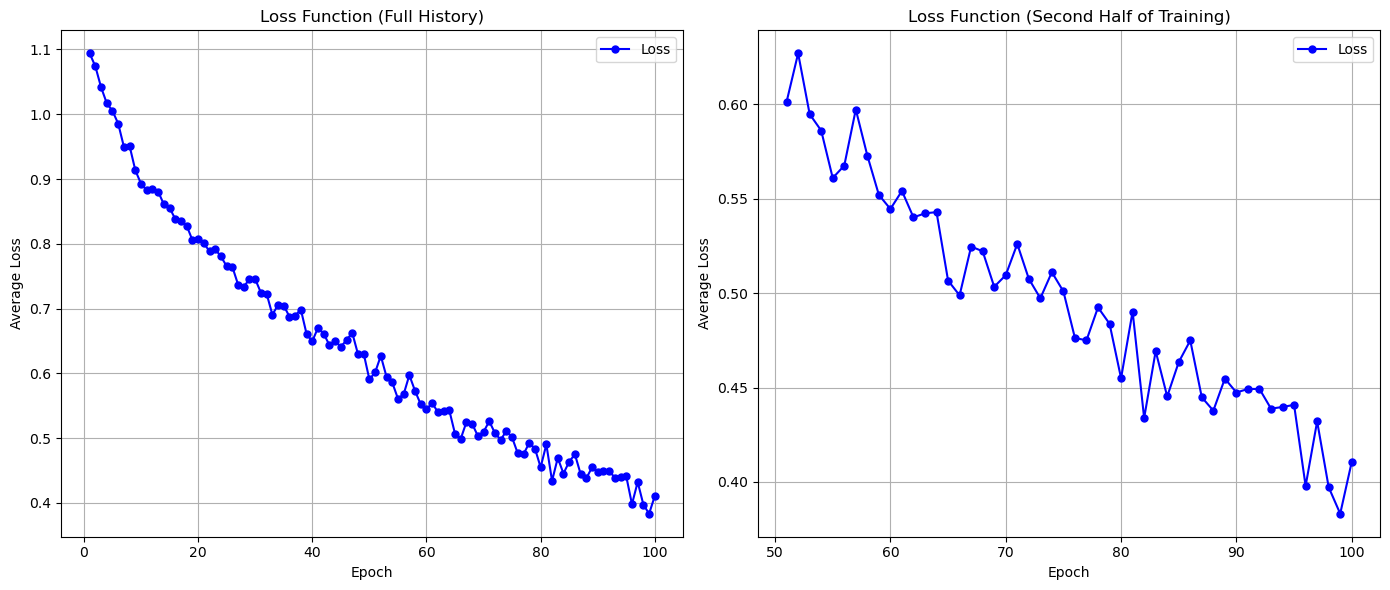

In [13]:
trainer1.plot_training_history()

#### Оценка

In [14]:
trainer1.evaluate(cifar100_001)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9406    0.9500    0.9453       500
  chimpanzee     0.9105    0.9560    0.9327       500
    mushroom     0.9745    0.9160    0.9443       500

    accuracy                         0.9407      1500
   macro avg     0.9418    0.9407    0.9408      1500
weighted avg     0.9418    0.9407    0.9408      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.7748    0.8600    0.8152       100
  chimpanzee     0.8041    0.7800    0.7919       100
    mushroom     0.8261    0.7600    0.7917       100

    accuracy                         0.8000       300
   macro avg     0.8017    0.8000    0.7996       300
weighted avg     0.8017    0.8000    0.7996       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [15]:
trainer1.save_model(cifar100_001)

Model saved as: cifar100_9fd52889-5ddd-4b72-84fa-b5f5cd858035.onnx
Model UUID: 9fd52889-5ddd-4b72-84fa-b5f5cd858035


### Эксперимент №2

#### Гиперпараметры

In [16]:
batch_size=2**5
epochs=100
criterion=nn.NLLLoss()
lr_rate = 1e-4
hidden_layers=[2**6, 2**10, 2**12, 2**10, 2**6]

#### Инициализация модели

In [17]:
%%time
trainer2 = CIFAR100Trainer(CLASSES, batch_size, lr_rate, criterion)

Используемое устройство: cuda
CPU times: user 155 ms, sys: 291 ms, total: 446 ms
Wall time: 330 ms


In [18]:
%%time
cifar100_002 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_prob=0.5, 
    num_classes=CLASSES.__len__()
)

CPU times: user 269 ms, sys: 29.9 ms, total: 299 ms
Wall time: 37.1 ms


#### Информация о модели

In [19]:
cifar100_002

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=4096, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=4096, out_features=1024, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=1024, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=64, out_features=3, bias=True)
  )
)

#### Обучение

In [20]:
%%time
trainer2.train(cifar100_002, epochs)

Epoch 1/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 89.01batch/s, loss=0.955712]


Epoch: 1/100, Loss: 1.064128


Epoch 2/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 87.40batch/s, loss=0.681746]


Epoch: 2/100, Loss: 0.850936


Epoch 3/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 88.61batch/s, loss=0.580405]


Epoch: 3/100, Loss: 0.707514


Epoch 4/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 88.95batch/s, loss=0.403530]


Epoch: 4/100, Loss: 0.656977


Epoch 5/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 89.42batch/s, loss=0.477312]


Epoch: 5/100, Loss: 0.583491


Epoch 6/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 88.28batch/s, loss=0.495322]


Epoch: 6/100, Loss: 0.559060


Epoch 7/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 89.77batch/s, loss=0.483306]


Epoch: 7/100, Loss: 0.532786


Epoch 8/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 86.85batch/s, loss=0.604827]


Epoch: 8/100, Loss: 0.521468


Epoch 9/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 87.90batch/s, loss=0.504138]


Epoch: 9/100, Loss: 0.488595


Epoch 10/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.29batch/s, loss=0.594128]


Epoch: 10/100, Loss: 0.451712


Epoch 11/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.95batch/s, loss=0.482777]


Epoch: 11/100, Loss: 0.463229


Epoch 12/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.87batch/s, loss=0.327652]


Epoch: 12/100, Loss: 0.435026


Epoch 13/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.84batch/s, loss=0.437077]


Epoch: 13/100, Loss: 0.422488


Epoch 14/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.04batch/s, loss=0.352963]


Epoch: 14/100, Loss: 0.401502


Epoch 15/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.91batch/s, loss=0.372804]


Epoch: 15/100, Loss: 0.353097


Epoch 16/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.03batch/s, loss=0.551686]


Epoch: 16/100, Loss: 0.372085


Epoch 17/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.70batch/s, loss=0.353118]


Epoch: 17/100, Loss: 0.345795


Epoch 18/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.36batch/s, loss=0.414761]


Epoch: 18/100, Loss: 0.375453


Epoch 19/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.07batch/s, loss=0.211323]


Epoch: 19/100, Loss: 0.341477


Epoch 20/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.07batch/s, loss=0.234566]


Epoch: 20/100, Loss: 0.308485


Epoch 21/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.49batch/s, loss=0.505300]


Epoch: 21/100, Loss: 0.298085


Epoch 22/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.93batch/s, loss=0.324784]


Epoch: 22/100, Loss: 0.321161


Epoch 23/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 92.41batch/s, loss=0.207459]


Epoch: 23/100, Loss: 0.287650


Epoch 24/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 94.31batch/s, loss=0.113766]


Epoch: 24/100, Loss: 0.265241


Epoch 25/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.06batch/s, loss=0.516779]


Epoch: 25/100, Loss: 0.297493


Epoch 26/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.45batch/s, loss=0.193633]


Epoch: 26/100, Loss: 0.245098


Epoch 27/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.11batch/s, loss=0.352428]


Epoch: 27/100, Loss: 0.268243


Epoch 28/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.27batch/s, loss=0.111204]


Epoch: 28/100, Loss: 0.250953


Epoch 29/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.14batch/s, loss=0.227138]


Epoch: 29/100, Loss: 0.262675


Epoch 30/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.99batch/s, loss=0.299751]


Epoch: 30/100, Loss: 0.261130


Epoch 31/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.58batch/s, loss=0.175885]


Epoch: 31/100, Loss: 0.245474


Epoch 32/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.43batch/s, loss=0.224574]


Epoch: 32/100, Loss: 0.205110


Epoch 33/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.37batch/s, loss=0.133334]


Epoch: 33/100, Loss: 0.220184


Epoch 34/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.07batch/s, loss=0.145672]


Epoch: 34/100, Loss: 0.210627


Epoch 35/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.60batch/s, loss=0.131433]


Epoch: 35/100, Loss: 0.217516


Epoch 36/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.89batch/s, loss=0.274301]


Epoch: 36/100, Loss: 0.215095


Epoch 37/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 92.38batch/s, loss=0.099091]


Epoch: 37/100, Loss: 0.204244


Epoch 38/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 92.98batch/s, loss=0.489040]


Epoch: 38/100, Loss: 0.200978


Epoch 39/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.45batch/s, loss=0.088634]


Epoch: 39/100, Loss: 0.193370


Epoch 40/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.38batch/s, loss=0.060134]


Epoch: 40/100, Loss: 0.164909


Epoch 41/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.82batch/s, loss=0.050386]


Epoch: 41/100, Loss: 0.166731


Epoch 42/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.72batch/s, loss=0.180197]


Epoch: 42/100, Loss: 0.168780


Epoch 43/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.45batch/s, loss=0.191527]


Epoch: 43/100, Loss: 0.197567


Epoch 44/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.47batch/s, loss=0.192670]


Epoch: 44/100, Loss: 0.170625


Epoch 45/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.50batch/s, loss=0.066257]


Epoch: 45/100, Loss: 0.172371


Epoch 46/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.59batch/s, loss=0.093302]


Epoch: 46/100, Loss: 0.182652


Epoch 47/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.43batch/s, loss=0.079983]


Epoch: 47/100, Loss: 0.163496


Epoch 48/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.12batch/s, loss=0.107853]


Epoch: 48/100, Loss: 0.162079


Epoch 49/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.20batch/s, loss=0.060566]


Epoch: 49/100, Loss: 0.177724


Epoch 50/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.21batch/s, loss=0.083532]


Epoch: 50/100, Loss: 0.183391


Epoch 51/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.01batch/s, loss=0.181057]


Epoch: 51/100, Loss: 0.192282


Epoch 52/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.52batch/s, loss=0.141430]


Epoch: 52/100, Loss: 0.148364


Epoch 53/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 82.66batch/s, loss=0.100772]


Epoch: 53/100, Loss: 0.173968


Epoch 54/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 82.15batch/s, loss=0.227050]


Epoch: 54/100, Loss: 0.149158


Epoch 55/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.61batch/s, loss=0.038234]


Epoch: 55/100, Loss: 0.137092


Epoch 56/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.23batch/s, loss=0.197726]


Epoch: 56/100, Loss: 0.125547


Epoch 57/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.40batch/s, loss=0.084886]


Epoch: 57/100, Loss: 0.144952


Epoch 58/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.59batch/s, loss=0.072882]


Epoch: 58/100, Loss: 0.132969


Epoch 59/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.94batch/s, loss=0.156963]


Epoch: 59/100, Loss: 0.163447


Epoch 60/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 84.58batch/s, loss=0.112737]


Epoch: 60/100, Loss: 0.160035


Epoch 61/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.86batch/s, loss=0.202895]


Epoch: 61/100, Loss: 0.159270


Epoch 62/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.20batch/s, loss=0.049438]


Epoch: 62/100, Loss: 0.130427


Epoch 63/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.28batch/s, loss=0.280585]


Epoch: 63/100, Loss: 0.125864


Epoch 64/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.78batch/s, loss=0.214809]


Epoch: 64/100, Loss: 0.125229


Epoch 65/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.43batch/s, loss=0.078313]


Epoch: 65/100, Loss: 0.113750


Epoch 66/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.54batch/s, loss=0.109540]


Epoch: 66/100, Loss: 0.102210


Epoch 67/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.15batch/s, loss=0.286825]


Epoch: 67/100, Loss: 0.139258


Epoch 68/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.00batch/s, loss=0.065618]


Epoch: 68/100, Loss: 0.128599


Epoch 69/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.83batch/s, loss=0.122014]


Epoch: 69/100, Loss: 0.126721


Epoch 70/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.12batch/s, loss=0.056703]


Epoch: 70/100, Loss: 0.102705


Epoch 71/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.56batch/s, loss=0.273883]


Epoch: 71/100, Loss: 0.120432


Epoch 72/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.16batch/s, loss=0.245965]


Epoch: 72/100, Loss: 0.129067


Epoch 73/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.49batch/s, loss=0.041557]


Epoch: 73/100, Loss: 0.131215


Epoch 74/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.93batch/s, loss=0.201268]


Epoch: 74/100, Loss: 0.124676


Epoch 75/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 93.49batch/s, loss=0.006625]


Epoch: 75/100, Loss: 0.110789


Epoch 76/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 93.97batch/s, loss=0.060837]


Epoch: 76/100, Loss: 0.105619


Epoch 77/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.50batch/s, loss=0.128624]


Epoch: 77/100, Loss: 0.137222


Epoch 78/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.32batch/s, loss=0.099302]


Epoch: 78/100, Loss: 0.126811


Epoch 79/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.66batch/s, loss=0.281639]


Epoch: 79/100, Loss: 0.118850


Epoch 80/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.50batch/s, loss=0.165776]


Epoch: 80/100, Loss: 0.108710


Epoch 81/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.25batch/s, loss=0.045521]


Epoch: 81/100, Loss: 0.126677


Epoch 82/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.77batch/s, loss=0.053169]


Epoch: 82/100, Loss: 0.106052


Epoch 83/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.84batch/s, loss=0.009514]


Epoch: 83/100, Loss: 0.119245


Epoch 84/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.69batch/s, loss=0.262896]


Epoch: 84/100, Loss: 0.146167


Epoch 85/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.27batch/s, loss=0.217528]


Epoch: 85/100, Loss: 0.105815


Epoch 86/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.72batch/s, loss=0.098682]


Epoch: 86/100, Loss: 0.110183


Epoch 87/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.84batch/s, loss=0.178352]


Epoch: 87/100, Loss: 0.104856


Epoch 88/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.28batch/s, loss=0.036288]


Epoch: 88/100, Loss: 0.087557


Epoch 89/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.36batch/s, loss=0.097987]


Epoch: 89/100, Loss: 0.116623


Epoch 90/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.65batch/s, loss=0.026490]


Epoch: 90/100, Loss: 0.083208


Epoch 91/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.31batch/s, loss=0.178438]


Epoch: 91/100, Loss: 0.119784


Epoch 92/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.46batch/s, loss=0.676471]


Epoch: 92/100, Loss: 0.110572


Epoch 93/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.88batch/s, loss=0.105979]


Epoch: 93/100, Loss: 0.089183


Epoch 94/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.83batch/s, loss=0.044227]


Epoch: 94/100, Loss: 0.072440


Epoch 95/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.31batch/s, loss=0.001195]


Epoch: 95/100, Loss: 0.107426


Epoch 96/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 84.52batch/s, loss=0.040653]


Epoch: 96/100, Loss: 0.103913


Epoch 97/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.82batch/s, loss=0.151445]


Epoch: 97/100, Loss: 0.077330


Epoch 98/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.87batch/s, loss=0.018315]


Epoch: 98/100, Loss: 0.070720


Epoch 99/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.43batch/s, loss=0.026399]


Epoch: 99/100, Loss: 0.088485


Epoch 100/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 89.42batch/s, loss=0.155655]

Epoch: 100/100, Loss: 0.101158
CPU times: user 26 s, sys: 29.7 s, total: 55.7 s
Wall time: 53.2 s


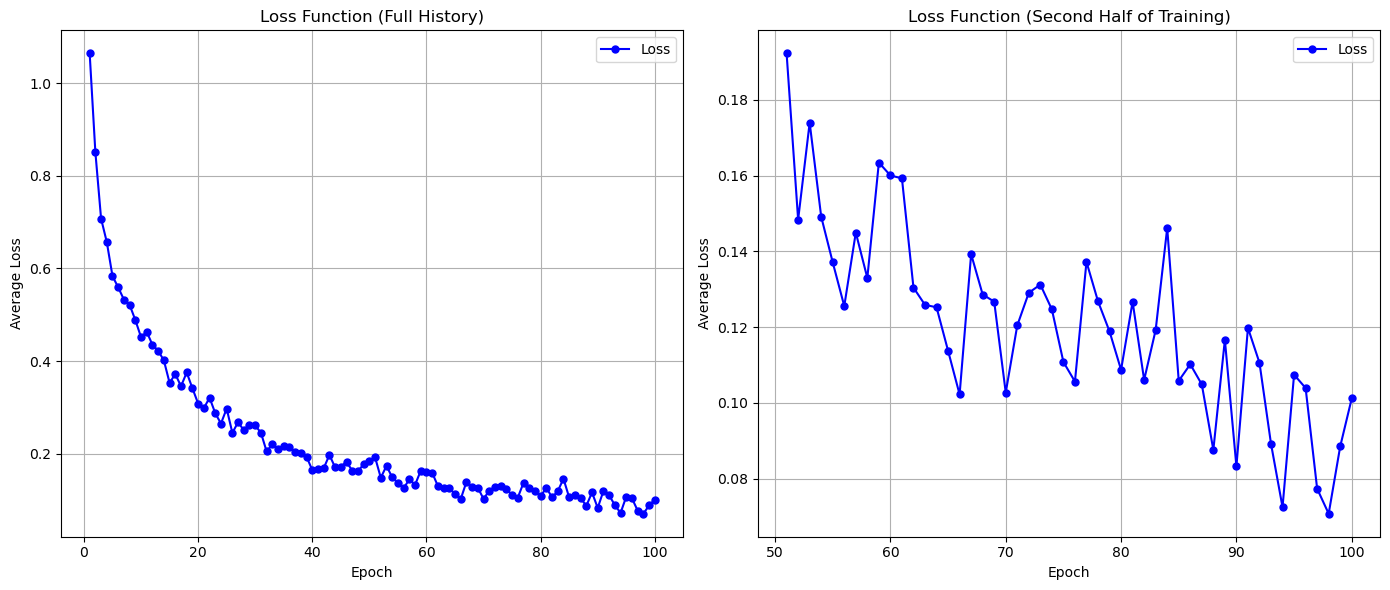

In [21]:
trainer2.plot_training_history()

#### Оценка

In [22]:
trainer2.evaluate(cifar100_002)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9980    0.9980    0.9980       500
  chimpanzee     0.9960    1.0000    0.9980       500
    mushroom     1.0000    0.9960    0.9980       500

    accuracy                         0.9980      1500
   macro avg     0.9980    0.9980    0.9980      1500
weighted avg     0.9980    0.9980    0.9980      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.9109    0.9200    0.9154       100
  chimpanzee     0.8558    0.8900    0.8725       100
    mushroom     0.8947    0.8500    0.8718       100

    accuracy                         0.8867       300
   macro avg     0.8871    0.8867    0.8866       300
weighted avg     0.8871    0.8867    0.8866       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [23]:
trainer2.save_model(cifar100_002)

Model saved as: cifar100_3d8ed642-e40d-43f9-8709-6da1867ed797.onnx
Model UUID: 3d8ed642-e40d-43f9-8709-6da1867ed797


### Эксперимент №3

#### Гиперпараметры

In [24]:
batch_size=2**5
epochs=100
criterion=nn.CrossEntropyLoss()
lr_rate = 1e-4
hidden_layers=[2**6, 2**10, 2**12, 2**10, 2**6]

#### Инициализация модели

In [25]:
%%time
trainer3 = CIFAR100Trainer(CLASSES, batch_size, lr_rate, criterion)

Используемое устройство: cuda
CPU times: user 192 ms, sys: 274 ms, total: 466 ms
Wall time: 317 ms


In [26]:
%%time
cifar100_003 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_prob=0.5, 
    num_classes=CLASSES.__len__()
)

CPU times: user 378 ms, sys: 31.7 ms, total: 410 ms
Wall time: 51 ms


#### Информация о модели

In [27]:
cifar100_003

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=64, out_features=1024, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=1024, out_features=4096, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=4096, out_features=1024, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=1024, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=64, out_features=3, bias=True)
  )
)

#### Обучение

In [28]:
%%time
trainer3.train(cifar100_003, epochs)

Epoch 1/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 89.85batch/s, loss=1.096786]


Epoch: 1/100, Loss: 1.067365


Epoch 2/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 83.87batch/s, loss=1.017346]


Epoch: 2/100, Loss: 0.864538


Epoch 3/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 86.65batch/s, loss=0.744453]


Epoch: 3/100, Loss: 0.712247


Epoch 4/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 85.11batch/s, loss=0.479304]


Epoch: 4/100, Loss: 0.653368


Epoch 5/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 87.95batch/s, loss=0.615285]


Epoch: 5/100, Loss: 0.596778


Epoch 6/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 84.19batch/s, loss=0.551853]


Epoch: 6/100, Loss: 0.573074


Epoch 7/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 81.42batch/s, loss=0.351867]


Epoch: 7/100, Loss: 0.540944


Epoch 8/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 90.34batch/s, loss=0.511467]


Epoch: 8/100, Loss: 0.522660


Epoch 9/100: 100%|██████████████████████████████████| 47/47 [00:00<00:00, 90.28batch/s, loss=0.751291]


Epoch: 9/100, Loss: 0.492441


Epoch 10/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 92.56batch/s, loss=0.339753]


Epoch: 10/100, Loss: 0.477572


Epoch 11/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.42batch/s, loss=0.511083]


Epoch: 11/100, Loss: 0.454131


Epoch 12/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.74batch/s, loss=0.382051]


Epoch: 12/100, Loss: 0.401653


Epoch 13/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.76batch/s, loss=0.710557]


Epoch: 13/100, Loss: 0.407575


Epoch 14/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.54batch/s, loss=0.567928]


Epoch: 14/100, Loss: 0.383679


Epoch 15/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.51batch/s, loss=0.230521]


Epoch: 15/100, Loss: 0.354651


Epoch 16/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.95batch/s, loss=0.487501]


Epoch: 16/100, Loss: 0.376500


Epoch 17/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.62batch/s, loss=0.144773]


Epoch: 17/100, Loss: 0.367496


Epoch 18/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.39batch/s, loss=0.258193]


Epoch: 18/100, Loss: 0.359705


Epoch 19/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.88batch/s, loss=0.314507]


Epoch: 19/100, Loss: 0.297559


Epoch 20/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.90batch/s, loss=0.312380]


Epoch: 20/100, Loss: 0.321961


Epoch 21/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.98batch/s, loss=0.373027]


Epoch: 21/100, Loss: 0.314013


Epoch 22/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.76batch/s, loss=0.443439]


Epoch: 22/100, Loss: 0.346945


Epoch 23/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.51batch/s, loss=0.473972]


Epoch: 23/100, Loss: 0.293515


Epoch 24/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.39batch/s, loss=0.368449]


Epoch: 24/100, Loss: 0.291715


Epoch 25/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.66batch/s, loss=0.455036]


Epoch: 25/100, Loss: 0.300483


Epoch 26/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.81batch/s, loss=0.166762]


Epoch: 26/100, Loss: 0.259937


Epoch 27/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.65batch/s, loss=0.132748]


Epoch: 27/100, Loss: 0.237547


Epoch 28/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.91batch/s, loss=0.197567]


Epoch: 28/100, Loss: 0.293266


Epoch 29/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.55batch/s, loss=0.194704]


Epoch: 29/100, Loss: 0.231050


Epoch 30/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.37batch/s, loss=0.221559]


Epoch: 30/100, Loss: 0.234027


Epoch 31/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.44batch/s, loss=0.214198]


Epoch: 31/100, Loss: 0.249421


Epoch 32/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.48batch/s, loss=0.141733]


Epoch: 32/100, Loss: 0.232744


Epoch 33/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.90batch/s, loss=0.298969]


Epoch: 33/100, Loss: 0.233050


Epoch 34/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.08batch/s, loss=0.185725]


Epoch: 34/100, Loss: 0.244944


Epoch 35/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.67batch/s, loss=0.072107]


Epoch: 35/100, Loss: 0.201690


Epoch 36/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.24batch/s, loss=0.267487]


Epoch: 36/100, Loss: 0.226576


Epoch 37/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.42batch/s, loss=0.223289]


Epoch: 37/100, Loss: 0.190554


Epoch 38/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.69batch/s, loss=0.411209]


Epoch: 38/100, Loss: 0.228301


Epoch 39/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 83.81batch/s, loss=0.136610]


Epoch: 39/100, Loss: 0.196505


Epoch 40/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.37batch/s, loss=0.228735]


Epoch: 40/100, Loss: 0.185942


Epoch 41/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.77batch/s, loss=0.308604]


Epoch: 41/100, Loss: 0.205349


Epoch 42/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.10batch/s, loss=0.351522]


Epoch: 42/100, Loss: 0.178671


Epoch 43/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.68batch/s, loss=0.324196]


Epoch: 43/100, Loss: 0.179149


Epoch 44/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.27batch/s, loss=0.173882]


Epoch: 44/100, Loss: 0.196194


Epoch 45/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.82batch/s, loss=0.196391]


Epoch: 45/100, Loss: 0.171994


Epoch 46/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.05batch/s, loss=0.131919]


Epoch: 46/100, Loss: 0.182329


Epoch 47/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.32batch/s, loss=0.113852]


Epoch: 47/100, Loss: 0.182469


Epoch 48/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.53batch/s, loss=0.030468]


Epoch: 48/100, Loss: 0.177518


Epoch 49/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.62batch/s, loss=0.188701]


Epoch: 49/100, Loss: 0.160624


Epoch 50/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.42batch/s, loss=0.199772]


Epoch: 50/100, Loss: 0.154823


Epoch 51/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.98batch/s, loss=0.347668]


Epoch: 51/100, Loss: 0.160607


Epoch 52/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.33batch/s, loss=0.089622]


Epoch: 52/100, Loss: 0.155317


Epoch 53/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 82.88batch/s, loss=0.147836]


Epoch: 53/100, Loss: 0.159443


Epoch 54/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 84.09batch/s, loss=0.041558]


Epoch: 54/100, Loss: 0.149609


Epoch 55/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.76batch/s, loss=0.089744]


Epoch: 55/100, Loss: 0.148949


Epoch 56/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.62batch/s, loss=0.278543]


Epoch: 56/100, Loss: 0.162359


Epoch 57/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.73batch/s, loss=0.079986]


Epoch: 57/100, Loss: 0.157921


Epoch 58/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.14batch/s, loss=0.075462]


Epoch: 58/100, Loss: 0.153255


Epoch 59/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.03batch/s, loss=0.622006]


Epoch: 59/100, Loss: 0.170929


Epoch 60/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 84.14batch/s, loss=0.232237]


Epoch: 60/100, Loss: 0.143063


Epoch 61/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.37batch/s, loss=0.269174]


Epoch: 61/100, Loss: 0.150659


Epoch 62/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.02batch/s, loss=0.393409]


Epoch: 62/100, Loss: 0.154844


Epoch 63/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.31batch/s, loss=0.127405]


Epoch: 63/100, Loss: 0.128893


Epoch 64/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.71batch/s, loss=0.198570]


Epoch: 64/100, Loss: 0.129539


Epoch 65/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.27batch/s, loss=0.127930]


Epoch: 65/100, Loss: 0.110729


Epoch 66/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.04batch/s, loss=0.184011]


Epoch: 66/100, Loss: 0.117551


Epoch 67/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.53batch/s, loss=0.122533]


Epoch: 67/100, Loss: 0.150795


Epoch 68/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.42batch/s, loss=0.223365]


Epoch: 68/100, Loss: 0.145426


Epoch 69/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.49batch/s, loss=0.085129]


Epoch: 69/100, Loss: 0.124912


Epoch 70/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 83.84batch/s, loss=0.120021]


Epoch: 70/100, Loss: 0.124720


Epoch 71/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.43batch/s, loss=0.024725]


Epoch: 71/100, Loss: 0.125114


Epoch 72/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.75batch/s, loss=0.051784]


Epoch: 72/100, Loss: 0.102447


Epoch 73/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.17batch/s, loss=0.101535]


Epoch: 73/100, Loss: 0.123151


Epoch 74/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.83batch/s, loss=0.018450]


Epoch: 74/100, Loss: 0.103397


Epoch 75/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.87batch/s, loss=0.055772]


Epoch: 75/100, Loss: 0.148913


Epoch 76/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.97batch/s, loss=0.066076]


Epoch: 76/100, Loss: 0.102991


Epoch 77/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.29batch/s, loss=0.075953]


Epoch: 77/100, Loss: 0.108047


Epoch 78/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.58batch/s, loss=0.134624]


Epoch: 78/100, Loss: 0.110227


Epoch 79/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.93batch/s, loss=0.077720]


Epoch: 79/100, Loss: 0.100548


Epoch 80/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.11batch/s, loss=0.084108]


Epoch: 80/100, Loss: 0.109819


Epoch 81/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.45batch/s, loss=0.188181]


Epoch: 81/100, Loss: 0.150803


Epoch 82/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.24batch/s, loss=0.153927]


Epoch: 82/100, Loss: 0.118118


Epoch 83/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.61batch/s, loss=0.054611]


Epoch: 83/100, Loss: 0.128985


Epoch 84/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.52batch/s, loss=0.043880]


Epoch: 84/100, Loss: 0.124531


Epoch 85/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.66batch/s, loss=0.052150]


Epoch: 85/100, Loss: 0.151736


Epoch 86/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 86.08batch/s, loss=0.064608]


Epoch: 86/100, Loss: 0.097009


Epoch 87/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.26batch/s, loss=0.024736]


Epoch: 87/100, Loss: 0.110915


Epoch 88/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 84.65batch/s, loss=0.050001]


Epoch: 88/100, Loss: 0.120703


Epoch 89/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.39batch/s, loss=0.065574]


Epoch: 89/100, Loss: 0.127020


Epoch 90/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.18batch/s, loss=0.019079]


Epoch: 90/100, Loss: 0.111622


Epoch 91/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.64batch/s, loss=0.048309]


Epoch: 91/100, Loss: 0.100123


Epoch 92/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 85.93batch/s, loss=0.017085]


Epoch: 92/100, Loss: 0.094626


Epoch 93/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 90.74batch/s, loss=0.002853]


Epoch: 93/100, Loss: 0.085577


Epoch 94/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 91.51batch/s, loss=0.096617]


Epoch: 94/100, Loss: 0.078797


Epoch 95/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.74batch/s, loss=0.073966]


Epoch: 95/100, Loss: 0.090109


Epoch 96/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 92.30batch/s, loss=0.022981]


Epoch: 96/100, Loss: 0.111021


Epoch 97/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 89.03batch/s, loss=0.032923]


Epoch: 97/100, Loss: 0.092426


Epoch 98/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 87.96batch/s, loss=0.084160]


Epoch: 98/100, Loss: 0.110520


Epoch 99/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 88.44batch/s, loss=0.006724]


Epoch: 99/100, Loss: 0.116826


Epoch 100/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 84.01batch/s, loss=0.053417]

Epoch: 100/100, Loss: 0.115268
CPU times: user 26.2 s, sys: 29.8 s, total: 56 s
Wall time: 53.6 s


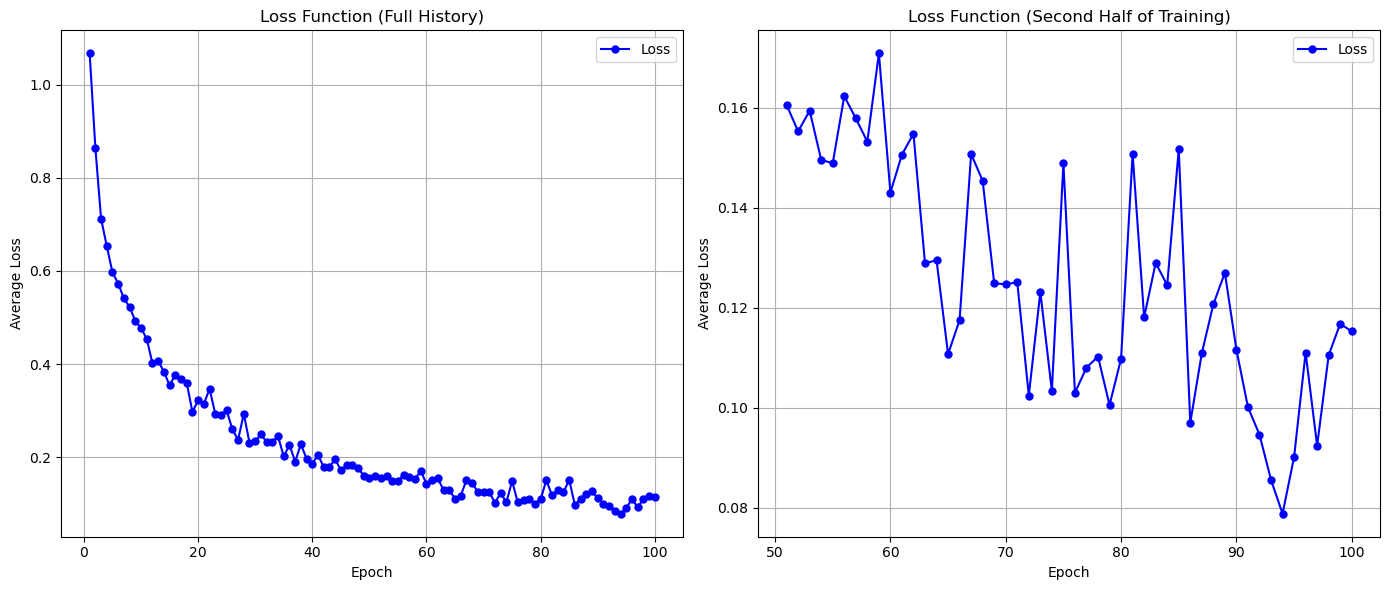

In [29]:
trainer3.plot_training_history()

#### Оценка

In [30]:
trainer3.evaluate(cifar100_003)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     1.0000    1.0000    1.0000       500
  chimpanzee     0.9960    1.0000    0.9980       500
    mushroom     1.0000    0.9960    0.9980       500

    accuracy                         0.9987      1500
   macro avg     0.9987    0.9987    0.9987      1500
weighted avg     0.9987    0.9987    0.9987      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8704    0.9400    0.9038       100
  chimpanzee     0.8723    0.8200    0.8454       100
    mushroom     0.8571    0.8400    0.8485       100

    accuracy                         0.8667       300
   macro avg     0.8666    0.8667    0.8659       300
weighted avg     0.8666    0.8667    0.8659       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [31]:
trainer3.save_model(cifar100_003)

Model saved as: cifar100_8cecb1e8-a588-4c5c-9b07-8067c70f4732.onnx
Model UUID: 8cecb1e8-a588-4c5c-9b07-8067c70f4732


### Эксперимент №4

#### Гиперпараметры

In [53]:
batch_size=2**5
epochs=100
criterion=nn.NLLLoss()
lr_rate = 1e-4
hidden_layers=[2**5, 2**6, 2**7, 2**7, 2**6, 2**5]

#### Инициализация модели

In [54]:
%%time
trainer4 = CIFAR100Trainer(CLASSES, batch_size, lr_rate, criterion)

Используемое устройство: cuda
CPU times: user 188 ms, sys: 314 ms, total: 503 ms
Wall time: 362 ms


In [55]:
%%time
cifar100_004 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_prob=0.5, 
    num_classes=CLASSES.__len__()
)

CPU times: user 16.3 ms, sys: 3.1 ms, total: 19.4 ms
Wall time: 2.35 ms


#### Информация о модели

In [56]:
cifar100_004

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=64, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=128, out_features=64, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=64, out_features=32, bias=True)
    (16): ReLU()
    (17): Dropout(p=0.5, inplace=False)
    (18): Linear(in_features=32, out_features=3, bias=True)
  )
)

#### Обучение

In [57]:
%%time
trainer4.train(cifar100_004, epochs)

Epoch 1/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 166.45batch/s, loss=1.074190]


Epoch: 1/100, Loss: 1.102295


Epoch 2/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 150.89batch/s, loss=1.078178]


Epoch: 2/100, Loss: 1.096558


Epoch 3/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 179.48batch/s, loss=1.074927]


Epoch: 3/100, Loss: 1.085132


Epoch 4/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 199.23batch/s, loss=1.019401]


Epoch: 4/100, Loss: 1.055809


Epoch 5/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 175.01batch/s, loss=0.986349]


Epoch: 5/100, Loss: 1.036325


Epoch 6/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 185.65batch/s, loss=1.039390]


Epoch: 6/100, Loss: 1.007686


Epoch 7/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 196.56batch/s, loss=1.057829]


Epoch: 7/100, Loss: 1.003817


Epoch 8/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 180.61batch/s, loss=1.006636]


Epoch: 8/100, Loss: 0.986073


Epoch 9/100: 100%|█████████████████████████████████| 47/47 [00:00<00:00, 176.51batch/s, loss=0.928839]


Epoch: 9/100, Loss: 0.978253


Epoch 10/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 172.94batch/s, loss=0.954112]


Epoch: 10/100, Loss: 0.970752


Epoch 11/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 180.63batch/s, loss=0.934874]


Epoch: 11/100, Loss: 0.948710


Epoch 12/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 187.26batch/s, loss=0.912319]


Epoch: 12/100, Loss: 0.946468


Epoch 13/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 181.28batch/s, loss=0.878795]


Epoch: 13/100, Loss: 0.932387


Epoch 14/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 191.65batch/s, loss=0.854395]


Epoch: 14/100, Loss: 0.938548


Epoch 15/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 164.80batch/s, loss=0.847540]


Epoch: 15/100, Loss: 0.915211


Epoch 16/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 178.06batch/s, loss=0.864670]


Epoch: 16/100, Loss: 0.917449


Epoch 17/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 174.25batch/s, loss=0.991205]


Epoch: 17/100, Loss: 0.903084


Epoch 18/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 176.01batch/s, loss=0.851399]


Epoch: 18/100, Loss: 0.895856


Epoch 19/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 176.23batch/s, loss=0.711375]


Epoch: 19/100, Loss: 0.881042


Epoch 20/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 190.02batch/s, loss=0.905921]


Epoch: 20/100, Loss: 0.859661


Epoch 21/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 178.22batch/s, loss=0.771223]


Epoch: 21/100, Loss: 0.847650


Epoch 22/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 187.64batch/s, loss=0.812948]


Epoch: 22/100, Loss: 0.833482


Epoch 23/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 186.07batch/s, loss=0.726955]


Epoch: 23/100, Loss: 0.838921


Epoch 24/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 187.76batch/s, loss=0.709832]


Epoch: 24/100, Loss: 0.798952


Epoch 25/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 169.12batch/s, loss=0.643326]


Epoch: 25/100, Loss: 0.780353


Epoch 26/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 180.79batch/s, loss=0.693765]


Epoch: 26/100, Loss: 0.753183


Epoch 27/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 174.58batch/s, loss=0.749857]


Epoch: 27/100, Loss: 0.755146


Epoch 28/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 177.81batch/s, loss=0.785321]


Epoch: 28/100, Loss: 0.701663


Epoch 29/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 176.67batch/s, loss=1.129846]


Epoch: 29/100, Loss: 0.731982


Epoch 30/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 191.25batch/s, loss=0.725046]


Epoch: 30/100, Loss: 0.702653


Epoch 31/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 196.28batch/s, loss=0.708454]


Epoch: 31/100, Loss: 0.706816


Epoch 32/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 197.94batch/s, loss=0.679314]


Epoch: 32/100, Loss: 0.698853


Epoch 33/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 175.44batch/s, loss=0.574137]


Epoch: 33/100, Loss: 0.655557


Epoch 34/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 180.55batch/s, loss=0.739685]


Epoch: 34/100, Loss: 0.643566


Epoch 35/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 174.71batch/s, loss=0.504359]


Epoch: 35/100, Loss: 0.658949


Epoch 36/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 175.20batch/s, loss=0.650226]


Epoch: 36/100, Loss: 0.628734


Epoch 37/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 172.61batch/s, loss=0.531824]


Epoch: 37/100, Loss: 0.612621


Epoch 38/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 176.40batch/s, loss=0.568926]


Epoch: 38/100, Loss: 0.603847


Epoch 39/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 172.87batch/s, loss=0.475200]


Epoch: 39/100, Loss: 0.563923


Epoch 40/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 189.19batch/s, loss=0.671515]


Epoch: 40/100, Loss: 0.606259


Epoch 41/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 178.73batch/s, loss=0.473627]


Epoch: 41/100, Loss: 0.580760


Epoch 42/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 197.60batch/s, loss=0.692722]


Epoch: 42/100, Loss: 0.567444


Epoch 43/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 189.34batch/s, loss=1.268870]


Epoch: 43/100, Loss: 0.565958


Epoch 44/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 172.32batch/s, loss=0.612611]


Epoch: 44/100, Loss: 0.557319


Epoch 45/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 179.82batch/s, loss=0.699299]


Epoch: 45/100, Loss: 0.586560


Epoch 46/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 173.17batch/s, loss=0.628881]


Epoch: 46/100, Loss: 0.546208


Epoch 47/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 194.07batch/s, loss=0.755186]


Epoch: 47/100, Loss: 0.541999


Epoch 48/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 175.21batch/s, loss=0.547300]


Epoch: 48/100, Loss: 0.515043


Epoch 49/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 179.68batch/s, loss=0.353926]


Epoch: 49/100, Loss: 0.544319


Epoch 50/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 173.65batch/s, loss=0.543511]


Epoch: 50/100, Loss: 0.534940


Epoch 51/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 170.16batch/s, loss=0.397515]


Epoch: 51/100, Loss: 0.515458


Epoch 52/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 166.95batch/s, loss=0.216550]


Epoch: 52/100, Loss: 0.477955


Epoch 53/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 166.18batch/s, loss=0.468784]


Epoch: 53/100, Loss: 0.489643


Epoch 54/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 177.32batch/s, loss=0.714266]


Epoch: 54/100, Loss: 0.468403


Epoch 55/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 174.28batch/s, loss=0.377239]


Epoch: 55/100, Loss: 0.467257


Epoch 56/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 176.00batch/s, loss=0.320863]


Epoch: 56/100, Loss: 0.493702


Epoch 57/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 178.00batch/s, loss=0.276966]


Epoch: 57/100, Loss: 0.458854


Epoch 58/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 182.26batch/s, loss=0.691593]


Epoch: 58/100, Loss: 0.467524


Epoch 59/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 182.33batch/s, loss=0.580356]


Epoch: 59/100, Loss: 0.444378


Epoch 60/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 180.69batch/s, loss=0.399135]


Epoch: 60/100, Loss: 0.445610


Epoch 61/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 179.90batch/s, loss=0.660802]


Epoch: 61/100, Loss: 0.433562


Epoch 62/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 171.65batch/s, loss=0.470153]


Epoch: 62/100, Loss: 0.462208


Epoch 63/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 176.27batch/s, loss=0.530823]


Epoch: 63/100, Loss: 0.437620


Epoch 64/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 181.68batch/s, loss=0.658464]


Epoch: 64/100, Loss: 0.408652


Epoch 65/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 177.65batch/s, loss=0.441031]


Epoch: 65/100, Loss: 0.428812


Epoch 66/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 188.96batch/s, loss=0.288467]


Epoch: 66/100, Loss: 0.407272


Epoch 67/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 185.29batch/s, loss=0.377460]


Epoch: 67/100, Loss: 0.396149


Epoch 68/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 165.20batch/s, loss=0.720457]


Epoch: 68/100, Loss: 0.385696


Epoch 69/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 176.39batch/s, loss=0.455251]


Epoch: 69/100, Loss: 0.417131


Epoch 70/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 172.95batch/s, loss=0.395637]


Epoch: 70/100, Loss: 0.397997


Epoch 71/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 174.21batch/s, loss=0.436829]


Epoch: 71/100, Loss: 0.407564


Epoch 72/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 166.26batch/s, loss=0.571041]


Epoch: 72/100, Loss: 0.371076


Epoch 73/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 173.15batch/s, loss=0.513314]


Epoch: 73/100, Loss: 0.406642


Epoch 74/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 182.42batch/s, loss=1.448510]


Epoch: 74/100, Loss: 0.420718


Epoch 75/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 192.34batch/s, loss=0.462814]


Epoch: 75/100, Loss: 0.395325


Epoch 76/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 169.69batch/s, loss=0.651284]


Epoch: 76/100, Loss: 0.389288


Epoch 77/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 163.10batch/s, loss=0.381430]


Epoch: 77/100, Loss: 0.389645


Epoch 78/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 169.98batch/s, loss=0.367239]


Epoch: 78/100, Loss: 0.378897


Epoch 79/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 181.96batch/s, loss=0.231683]


Epoch: 79/100, Loss: 0.390640


Epoch 80/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 181.35batch/s, loss=0.289189]


Epoch: 80/100, Loss: 0.359993


Epoch 81/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 175.53batch/s, loss=0.387895]


Epoch: 81/100, Loss: 0.337836


Epoch 82/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 161.20batch/s, loss=0.334513]


Epoch: 82/100, Loss: 0.351358


Epoch 83/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 168.07batch/s, loss=0.159238]


Epoch: 83/100, Loss: 0.366352


Epoch 84/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 168.21batch/s, loss=0.400008]


Epoch: 84/100, Loss: 0.327593


Epoch 85/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 175.82batch/s, loss=0.297839]


Epoch: 85/100, Loss: 0.361016


Epoch 86/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 172.90batch/s, loss=0.119767]


Epoch: 86/100, Loss: 0.353007


Epoch 87/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 182.46batch/s, loss=0.294478]


Epoch: 87/100, Loss: 0.366107


Epoch 88/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 175.74batch/s, loss=0.493120]


Epoch: 88/100, Loss: 0.357992


Epoch 89/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 170.40batch/s, loss=0.148557]


Epoch: 89/100, Loss: 0.345984


Epoch 90/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 166.05batch/s, loss=0.314398]


Epoch: 90/100, Loss: 0.357747


Epoch 91/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 168.43batch/s, loss=0.315009]


Epoch: 91/100, Loss: 0.337141


Epoch 92/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 168.59batch/s, loss=0.262141]


Epoch: 92/100, Loss: 0.327006


Epoch 93/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 170.17batch/s, loss=0.237793]


Epoch: 93/100, Loss: 0.296236


Epoch 94/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 169.79batch/s, loss=0.240667]


Epoch: 94/100, Loss: 0.311439


Epoch 95/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 171.30batch/s, loss=0.332819]


Epoch: 95/100, Loss: 0.312172


Epoch 96/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 165.07batch/s, loss=0.195658]


Epoch: 96/100, Loss: 0.312721


Epoch 97/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 171.95batch/s, loss=0.424808]


Epoch: 97/100, Loss: 0.323325


Epoch 98/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 176.00batch/s, loss=0.254138]


Epoch: 98/100, Loss: 0.313329


Epoch 99/100: 100%|████████████████████████████████| 47/47 [00:00<00:00, 184.58batch/s, loss=0.347605]


Epoch: 99/100, Loss: 0.337249


Epoch 100/100: 100%|███████████████████████████████| 47/47 [00:00<00:00, 202.48batch/s, loss=0.569661]


Epoch: 100/100, Loss: 0.320085
CPU times: user 21.8 s, sys: 6.53 s, total: 28.3 s
Wall time: 26.8 s


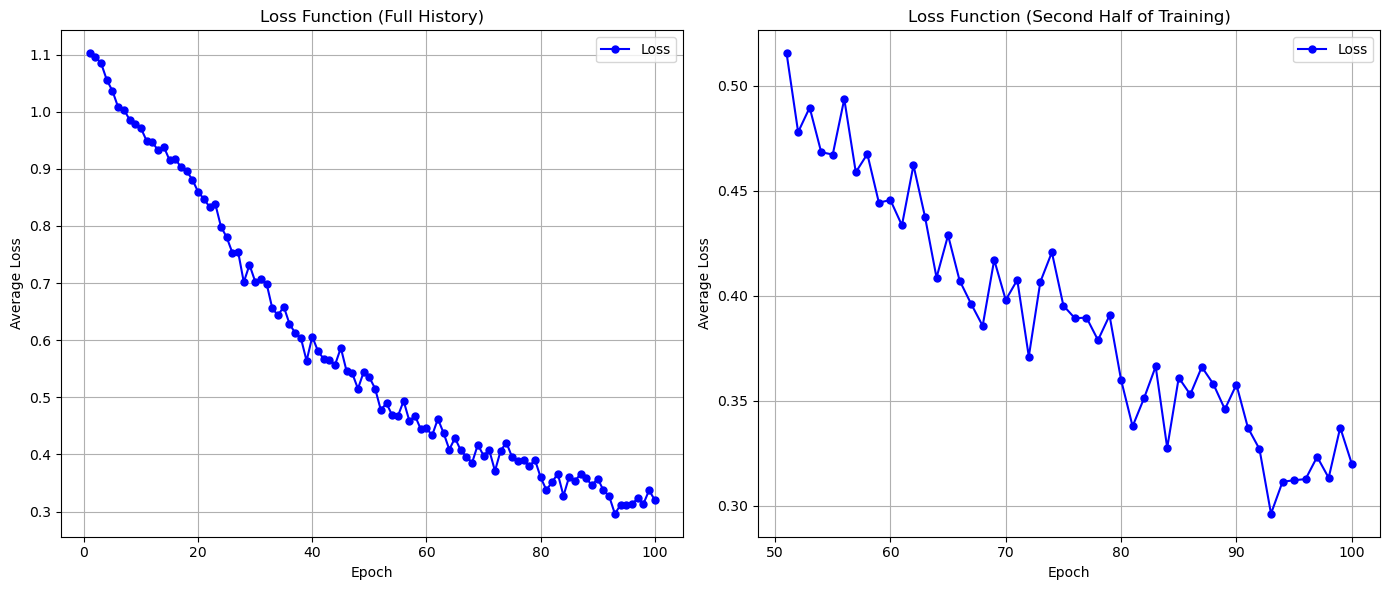

In [58]:
trainer4.plot_training_history()

#### Оценка

In [59]:
trainer4.evaluate(cifar100_004)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     0.9663    0.9740    0.9701       500
  chimpanzee     0.9131    0.9880    0.9491       500
    mushroom     0.9846    0.8960    0.9382       500

    accuracy                         0.9527      1500
   macro avg     0.9547    0.9527    0.9525      1500
weighted avg     0.9547    0.9527    0.9525      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8257    0.9000    0.8612       100
  chimpanzee     0.7426    0.7500    0.7463       100
    mushroom     0.8111    0.7300    0.7684       100

    accuracy                         0.7933       300
   macro avg     0.7931    0.7933    0.7920       300
weighted avg     0.7931    0.7933    0.7920       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [60]:
trainer4.save_model(cifar100_004)

Model saved as: cifar100_aadfc449-56ea-4ee5-a877-ec7e0ed50789.onnx
Model UUID: aadfc449-56ea-4ee5-a877-ec7e0ed50789


### Эксперимент №5

#### Гиперпараметры

In [63]:
batch_size=2**5
epochs=1000
criterion=nn.NLLLoss()
lr_rate = 1e-4
hidden_layers=[2**5, 2**7, 2**10, 2**7, 2**5]

#### Инициализация модели

In [64]:
%%time
trainer5 = CIFAR100Trainer(CLASSES, batch_size, lr_rate, criterion)

Используемое устройство: cuda
CPU times: user 193 ms, sys: 280 ms, total: 473 ms
Wall time: 330 ms


In [65]:
%%time
cifar100_005 = CIFAR100Model(
    hidden_layers=hidden_layers, 
    dropout_prob=0.5, 
    num_classes=CLASSES.__len__()
)

CPU times: user 27.4 ms, sys: 0 ns, total: 27.4 ms
Wall time: 3.32 ms


#### Информация о модели

In [66]:
cifar100_005

CIFAR100Model(
  (norm): Normalize()
  (seq): Sequential(
    (0): Linear(in_features=3072, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=32, out_features=128, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=128, out_features=1024, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=1024, out_features=128, bias=True)
    (10): ReLU()
    (11): Dropout(p=0.5, inplace=False)
    (12): Linear(in_features=128, out_features=32, bias=True)
    (13): ReLU()
    (14): Dropout(p=0.5, inplace=False)
    (15): Linear(in_features=32, out_features=3, bias=True)
  )
)

#### Обучение

In [67]:
%%time
trainer5.train(cifar100_005, epochs)

Epoch 1/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 189.62batch/s, loss=1.123906]


Epoch: 1/1000, Loss: 1.099638


Epoch 2/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 228.47batch/s, loss=1.103884]


Epoch: 2/1000, Loss: 1.082496


Epoch 3/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 248.03batch/s, loss=1.023762]


Epoch: 3/1000, Loss: 1.048739


Epoch 4/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 214.72batch/s, loss=0.824424]


Epoch: 4/1000, Loss: 1.000991


Epoch 5/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 219.46batch/s, loss=0.868757]


Epoch: 5/1000, Loss: 0.942000


Epoch 6/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 282.38batch/s, loss=0.924107]


Epoch: 6/1000, Loss: 0.891169


Epoch 7/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 263.17batch/s, loss=0.895985]


Epoch: 7/1000, Loss: 0.848714


Epoch 8/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 236.36batch/s, loss=0.858955]


Epoch: 8/1000, Loss: 0.828588


Epoch 9/1000: 100%|████████████████████████████████| 47/47 [00:00<00:00, 259.35batch/s, loss=0.807448]


Epoch: 9/1000, Loss: 0.812080


Epoch 10/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 208.28batch/s, loss=0.834280]


Epoch: 10/1000, Loss: 0.781963


Epoch 11/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 234.51batch/s, loss=0.757897]


Epoch: 11/1000, Loss: 0.791368


Epoch 12/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 238.56batch/s, loss=0.603043]


Epoch: 12/1000, Loss: 0.776679


Epoch 13/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 243.83batch/s, loss=0.965717]


Epoch: 13/1000, Loss: 0.749007


Epoch 14/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 244.77batch/s, loss=0.634666]


Epoch: 14/1000, Loss: 0.725036


Epoch 15/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 233.18batch/s, loss=0.818189]


Epoch: 15/1000, Loss: 0.714230


Epoch 16/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 254.17batch/s, loss=0.520542]


Epoch: 16/1000, Loss: 0.726954


Epoch 17/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 265.24batch/s, loss=0.711717]


Epoch: 17/1000, Loss: 0.713629


Epoch 18/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 239.66batch/s, loss=0.671130]


Epoch: 18/1000, Loss: 0.700892


Epoch 19/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 258.69batch/s, loss=0.668786]


Epoch: 19/1000, Loss: 0.689942


Epoch 20/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 251.11batch/s, loss=0.567774]


Epoch: 20/1000, Loss: 0.660908


Epoch 21/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 222.65batch/s, loss=0.672703]


Epoch: 21/1000, Loss: 0.631959


Epoch 22/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 222.85batch/s, loss=0.490031]


Epoch: 22/1000, Loss: 0.634645


Epoch 23/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 292.87batch/s, loss=0.592963]


Epoch: 23/1000, Loss: 0.613492


Epoch 24/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 248.57batch/s, loss=0.712083]


Epoch: 24/1000, Loss: 0.600932


Epoch 25/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 249.29batch/s, loss=0.640197]


Epoch: 25/1000, Loss: 0.605900


Epoch 26/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 239.30batch/s, loss=0.547962]


Epoch: 26/1000, Loss: 0.566742


Epoch 27/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 245.94batch/s, loss=0.743722]


Epoch: 27/1000, Loss: 0.571315


Epoch 28/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 257.20batch/s, loss=0.572500]


Epoch: 28/1000, Loss: 0.531765


Epoch 29/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 238.10batch/s, loss=0.406871]


Epoch: 29/1000, Loss: 0.532903


Epoch 30/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 253.44batch/s, loss=0.444929]


Epoch: 30/1000, Loss: 0.538378


Epoch 31/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 236.23batch/s, loss=0.487684]


Epoch: 31/1000, Loss: 0.504488


Epoch 32/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 239.52batch/s, loss=0.404018]


Epoch: 32/1000, Loss: 0.480759


Epoch 33/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 226.39batch/s, loss=0.402601]


Epoch: 33/1000, Loss: 0.500761


Epoch 34/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 216.53batch/s, loss=0.363017]


Epoch: 34/1000, Loss: 0.464800


Epoch 35/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 246.96batch/s, loss=0.354678]


Epoch: 35/1000, Loss: 0.451654


Epoch 36/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 272.95batch/s, loss=0.582660]


Epoch: 36/1000, Loss: 0.477686


Epoch 37/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 239.00batch/s, loss=0.212102]


Epoch: 37/1000, Loss: 0.477807


Epoch 38/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 235.36batch/s, loss=0.370850]


Epoch: 38/1000, Loss: 0.447757


Epoch 39/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 285.74batch/s, loss=0.301939]


Epoch: 39/1000, Loss: 0.426124


Epoch 40/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 284.92batch/s, loss=0.496094]


Epoch: 40/1000, Loss: 0.404982


Epoch 41/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 269.37batch/s, loss=0.276756]


Epoch: 41/1000, Loss: 0.435851


Epoch 42/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 246.18batch/s, loss=0.690184]


Epoch: 42/1000, Loss: 0.417579


Epoch 43/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 259.96batch/s, loss=0.378030]


Epoch: 43/1000, Loss: 0.425596


Epoch 44/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 251.91batch/s, loss=0.500990]


Epoch: 44/1000, Loss: 0.403204


Epoch 45/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 272.37batch/s, loss=0.563888]


Epoch: 45/1000, Loss: 0.406701


Epoch 46/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 259.15batch/s, loss=0.351308]


Epoch: 46/1000, Loss: 0.397883


Epoch 47/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 233.42batch/s, loss=0.409264]


Epoch: 47/1000, Loss: 0.388069


Epoch 48/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 224.52batch/s, loss=0.586342]


Epoch: 48/1000, Loss: 0.362304


Epoch 49/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 188.46batch/s, loss=0.290985]


Epoch: 49/1000, Loss: 0.370436


Epoch 50/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 212.55batch/s, loss=0.189950]


Epoch: 50/1000, Loss: 0.394067


Epoch 51/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 191.47batch/s, loss=0.446884]


Epoch: 51/1000, Loss: 0.379118


Epoch 52/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 219.22batch/s, loss=0.162329]


Epoch: 52/1000, Loss: 0.370893


Epoch 53/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 218.76batch/s, loss=0.186646]


Epoch: 53/1000, Loss: 0.352302


Epoch 54/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 205.69batch/s, loss=0.347859]


Epoch: 54/1000, Loss: 0.338121


Epoch 55/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 179.84batch/s, loss=0.146666]


Epoch: 55/1000, Loss: 0.346760


Epoch 56/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 220.04batch/s, loss=0.226493]


Epoch: 56/1000, Loss: 0.340204


Epoch 57/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 253.07batch/s, loss=0.636157]


Epoch: 57/1000, Loss: 0.333725


Epoch 58/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 262.17batch/s, loss=0.403449]


Epoch: 58/1000, Loss: 0.351412


Epoch 59/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 225.90batch/s, loss=0.469084]


Epoch: 59/1000, Loss: 0.330786


Epoch 60/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 242.58batch/s, loss=0.436259]


Epoch: 60/1000, Loss: 0.346613


Epoch 61/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 262.65batch/s, loss=0.246215]


Epoch: 61/1000, Loss: 0.305726


Epoch 62/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 246.96batch/s, loss=0.224389]


Epoch: 62/1000, Loss: 0.349267


Epoch 63/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 189.79batch/s, loss=0.356018]


Epoch: 63/1000, Loss: 0.297553


Epoch 64/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 228.54batch/s, loss=0.206665]


Epoch: 64/1000, Loss: 0.314351


Epoch 65/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 221.61batch/s, loss=0.262501]


Epoch: 65/1000, Loss: 0.320384


Epoch 66/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 229.42batch/s, loss=0.245687]


Epoch: 66/1000, Loss: 0.332853


Epoch 67/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 218.84batch/s, loss=0.209927]


Epoch: 67/1000, Loss: 0.302013


Epoch 68/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 240.00batch/s, loss=0.303026]


Epoch: 68/1000, Loss: 0.302989


Epoch 69/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 201.78batch/s, loss=0.304068]


Epoch: 69/1000, Loss: 0.320675


Epoch 70/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 240.07batch/s, loss=0.446564]


Epoch: 70/1000, Loss: 0.308744


Epoch 71/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 180.98batch/s, loss=0.461939]


Epoch: 71/1000, Loss: 0.276351


Epoch 72/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 271.53batch/s, loss=0.280319]


Epoch: 72/1000, Loss: 0.261619


Epoch 73/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 262.78batch/s, loss=0.263662]


Epoch: 73/1000, Loss: 0.315777


Epoch 74/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 282.99batch/s, loss=0.436737]


Epoch: 74/1000, Loss: 0.306362


Epoch 75/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 302.40batch/s, loss=0.379925]


Epoch: 75/1000, Loss: 0.295462


Epoch 76/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 255.05batch/s, loss=0.693810]


Epoch: 76/1000, Loss: 0.299950


Epoch 77/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 224.02batch/s, loss=0.238930]


Epoch: 77/1000, Loss: 0.282937


Epoch 78/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 230.41batch/s, loss=0.177607]


Epoch: 78/1000, Loss: 0.269551


Epoch 79/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 214.67batch/s, loss=0.333069]


Epoch: 79/1000, Loss: 0.267806


Epoch 80/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 223.84batch/s, loss=0.295387]


Epoch: 80/1000, Loss: 0.274593


Epoch 81/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 225.50batch/s, loss=0.585735]


Epoch: 81/1000, Loss: 0.273019


Epoch 82/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 249.48batch/s, loss=0.374020]


Epoch: 82/1000, Loss: 0.287093


Epoch 83/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 228.78batch/s, loss=0.219150]


Epoch: 83/1000, Loss: 0.242625


Epoch 84/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 218.64batch/s, loss=0.329085]


Epoch: 84/1000, Loss: 0.262285


Epoch 85/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 211.88batch/s, loss=0.228270]


Epoch: 85/1000, Loss: 0.265948


Epoch 86/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 246.73batch/s, loss=0.264694]


Epoch: 86/1000, Loss: 0.259106


Epoch 87/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 202.56batch/s, loss=0.279383]


Epoch: 87/1000, Loss: 0.254310


Epoch 88/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 190.33batch/s, loss=0.436608]


Epoch: 88/1000, Loss: 0.237392


Epoch 89/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 195.03batch/s, loss=0.100576]


Epoch: 89/1000, Loss: 0.239106


Epoch 90/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 203.73batch/s, loss=0.353752]


Epoch: 90/1000, Loss: 0.261831


Epoch 91/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 220.79batch/s, loss=0.232426]


Epoch: 91/1000, Loss: 0.240237


Epoch 92/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 282.40batch/s, loss=0.240849]


Epoch: 92/1000, Loss: 0.204428


Epoch 93/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 248.14batch/s, loss=0.433442]


Epoch: 93/1000, Loss: 0.233048


Epoch 94/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 256.61batch/s, loss=0.605511]


Epoch: 94/1000, Loss: 0.255650


Epoch 95/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 235.84batch/s, loss=0.165895]


Epoch: 95/1000, Loss: 0.243713


Epoch 96/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 266.73batch/s, loss=0.386444]


Epoch: 96/1000, Loss: 0.236553


Epoch 97/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 241.47batch/s, loss=0.239442]


Epoch: 97/1000, Loss: 0.225103


Epoch 98/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 234.09batch/s, loss=0.191911]


Epoch: 98/1000, Loss: 0.203608


Epoch 99/1000: 100%|███████████████████████████████| 47/47 [00:00<00:00, 244.19batch/s, loss=0.224431]


Epoch: 99/1000, Loss: 0.250121


Epoch 100/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 294.86batch/s, loss=0.247968]


Epoch: 100/1000, Loss: 0.246828


Epoch 101/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.25batch/s, loss=0.313160]


Epoch: 101/1000, Loss: 0.242512


Epoch 102/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.83batch/s, loss=0.166463]


Epoch: 102/1000, Loss: 0.250470


Epoch 103/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 263.58batch/s, loss=0.154963]


Epoch: 103/1000, Loss: 0.237897


Epoch 104/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.56batch/s, loss=0.340269]


Epoch: 104/1000, Loss: 0.226850


Epoch 105/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.12batch/s, loss=0.136872]

Epoch: 105/1000, Loss: 0.245381



Epoch 106/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 208.00batch/s, loss=0.062282]


Epoch: 106/1000, Loss: 0.227716


Epoch 107/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 280.78batch/s, loss=0.173161]


Epoch: 107/1000, Loss: 0.207245


Epoch 108/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.12batch/s, loss=0.067059]


Epoch: 108/1000, Loss: 0.192002


Epoch 109/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.15batch/s, loss=0.340607]


Epoch: 109/1000, Loss: 0.206800


Epoch 110/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.96batch/s, loss=0.220321]


Epoch: 110/1000, Loss: 0.201049


Epoch 111/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.94batch/s, loss=0.131531]


Epoch: 111/1000, Loss: 0.220598


Epoch 112/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 202.22batch/s, loss=0.065556]


Epoch: 112/1000, Loss: 0.213107


Epoch 113/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.23batch/s, loss=0.140134]


Epoch: 113/1000, Loss: 0.240534


Epoch 114/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 195.24batch/s, loss=0.148248]


Epoch: 114/1000, Loss: 0.202910


Epoch 115/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 208.38batch/s, loss=0.112423]


Epoch: 115/1000, Loss: 0.212197


Epoch 116/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 205.35batch/s, loss=0.287198]


Epoch: 116/1000, Loss: 0.192600


Epoch 117/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 180.51batch/s, loss=0.225295]


Epoch: 117/1000, Loss: 0.190299


Epoch 118/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 169.47batch/s, loss=0.182465]


Epoch: 118/1000, Loss: 0.209959


Epoch 119/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 179.66batch/s, loss=0.065827]


Epoch: 119/1000, Loss: 0.188740


Epoch 120/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 183.37batch/s, loss=0.311057]


Epoch: 120/1000, Loss: 0.234744


Epoch 121/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.66batch/s, loss=0.081233]


Epoch: 121/1000, Loss: 0.193226


Epoch 122/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 196.62batch/s, loss=0.682501]


Epoch: 122/1000, Loss: 0.212348


Epoch 123/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.60batch/s, loss=0.586580]


Epoch: 123/1000, Loss: 0.183890


Epoch 124/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.92batch/s, loss=0.097675]


Epoch: 124/1000, Loss: 0.205291


Epoch 125/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.14batch/s, loss=0.073883]


Epoch: 125/1000, Loss: 0.183866


Epoch 126/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.40batch/s, loss=0.138935]


Epoch: 126/1000, Loss: 0.193995


Epoch 127/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.49batch/s, loss=0.125468]


Epoch: 127/1000, Loss: 0.148784


Epoch 128/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.96batch/s, loss=0.340942]


Epoch: 128/1000, Loss: 0.190109


Epoch 129/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.44batch/s, loss=0.310735]


Epoch: 129/1000, Loss: 0.174542


Epoch 130/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 187.59batch/s, loss=0.140396]


Epoch: 130/1000, Loss: 0.169829


Epoch 131/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.75batch/s, loss=0.641336]


Epoch: 131/1000, Loss: 0.166690


Epoch 132/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 202.73batch/s, loss=0.290088]


Epoch: 132/1000, Loss: 0.176178


Epoch 133/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.35batch/s, loss=0.154099]


Epoch: 133/1000, Loss: 0.181225


Epoch 134/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 193.51batch/s, loss=0.101086]


Epoch: 134/1000, Loss: 0.196099


Epoch 135/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 191.57batch/s, loss=0.090713]


Epoch: 135/1000, Loss: 0.186511


Epoch 136/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 205.17batch/s, loss=0.044699]


Epoch: 136/1000, Loss: 0.170665


Epoch 137/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 200.21batch/s, loss=0.107654]


Epoch: 137/1000, Loss: 0.172460


Epoch 138/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.08batch/s, loss=0.410434]


Epoch: 138/1000, Loss: 0.181115


Epoch 139/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.34batch/s, loss=0.243788]


Epoch: 139/1000, Loss: 0.149889


Epoch 140/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 202.54batch/s, loss=0.076237]


Epoch: 140/1000, Loss: 0.175018


Epoch 141/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.30batch/s, loss=0.120156]


Epoch: 141/1000, Loss: 0.154858


Epoch 142/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.42batch/s, loss=0.072111]


Epoch: 142/1000, Loss: 0.182106


Epoch 143/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.90batch/s, loss=0.052563]


Epoch: 143/1000, Loss: 0.157650


Epoch 144/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.12batch/s, loss=0.157004]


Epoch: 144/1000, Loss: 0.149218


Epoch 145/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 191.26batch/s, loss=0.063982]


Epoch: 145/1000, Loss: 0.158154


Epoch 146/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.51batch/s, loss=0.009225]


Epoch: 146/1000, Loss: 0.149934


Epoch 147/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.73batch/s, loss=0.081705]


Epoch: 147/1000, Loss: 0.169827


Epoch 148/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.43batch/s, loss=0.228105]


Epoch: 148/1000, Loss: 0.205656


Epoch 149/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.18batch/s, loss=0.186255]


Epoch: 149/1000, Loss: 0.163298


Epoch 150/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.98batch/s, loss=0.185722]


Epoch: 150/1000, Loss: 0.236273


Epoch 151/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.46batch/s, loss=0.191264]


Epoch: 151/1000, Loss: 0.161317


Epoch 152/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.98batch/s, loss=0.119633]


Epoch: 152/1000, Loss: 0.205862


Epoch 153/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.98batch/s, loss=0.279221]


Epoch: 153/1000, Loss: 0.156523


Epoch 154/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.94batch/s, loss=0.199534]


Epoch: 154/1000, Loss: 0.207044


Epoch 155/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.57batch/s, loss=0.184643]


Epoch: 155/1000, Loss: 0.143916


Epoch 156/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.42batch/s, loss=0.124622]


Epoch: 156/1000, Loss: 0.152404


Epoch 157/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.22batch/s, loss=0.096263]


Epoch: 157/1000, Loss: 0.132990


Epoch 158/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.44batch/s, loss=0.029855]


Epoch: 158/1000, Loss: 0.160210


Epoch 159/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.81batch/s, loss=0.055507]


Epoch: 159/1000, Loss: 0.156315


Epoch 160/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.09batch/s, loss=0.382035]


Epoch: 160/1000, Loss: 0.194477


Epoch 161/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.62batch/s, loss=0.085531]


Epoch: 161/1000, Loss: 0.178628


Epoch 162/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.30batch/s, loss=0.131382]


Epoch: 162/1000, Loss: 0.153766


Epoch 163/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 282.99batch/s, loss=0.027400]


Epoch: 163/1000, Loss: 0.181543


Epoch 164/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.19batch/s, loss=0.409555]


Epoch: 164/1000, Loss: 0.148838


Epoch 165/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.37batch/s, loss=0.107810]


Epoch: 165/1000, Loss: 0.155142


Epoch 166/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.89batch/s, loss=0.105438]


Epoch: 166/1000, Loss: 0.148791


Epoch 167/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 196.88batch/s, loss=0.354995]


Epoch: 167/1000, Loss: 0.150788


Epoch 168/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.23batch/s, loss=0.182206]


Epoch: 168/1000, Loss: 0.157010


Epoch 169/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.58batch/s, loss=0.039555]


Epoch: 169/1000, Loss: 0.137699


Epoch 170/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.23batch/s, loss=0.303080]


Epoch: 170/1000, Loss: 0.161724


Epoch 171/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.38batch/s, loss=0.203314]


Epoch: 171/1000, Loss: 0.144054


Epoch 172/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.30batch/s, loss=0.300036]


Epoch: 172/1000, Loss: 0.163790


Epoch 173/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.79batch/s, loss=0.202465]


Epoch: 173/1000, Loss: 0.151356


Epoch 174/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 182.65batch/s, loss=0.098865]


Epoch: 174/1000, Loss: 0.133174


Epoch 175/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.41batch/s, loss=0.088994]


Epoch: 175/1000, Loss: 0.144137


Epoch 176/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.55batch/s, loss=0.034035]


Epoch: 176/1000, Loss: 0.122902


Epoch 177/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.24batch/s, loss=0.009997]


Epoch: 177/1000, Loss: 0.162002


Epoch 178/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 270.62batch/s, loss=0.159139]


Epoch: 178/1000, Loss: 0.129555


Epoch 179/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.78batch/s, loss=0.160412]


Epoch: 179/1000, Loss: 0.142576


Epoch 180/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 203.58batch/s, loss=0.222898]


Epoch: 180/1000, Loss: 0.134924


Epoch 181/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.06batch/s, loss=0.165442]


Epoch: 181/1000, Loss: 0.148748


Epoch 182/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 204.37batch/s, loss=0.034326]


Epoch: 182/1000, Loss: 0.177005


Epoch 183/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.33batch/s, loss=0.049680]


Epoch: 183/1000, Loss: 0.160305


Epoch 184/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.23batch/s, loss=0.175020]


Epoch: 184/1000, Loss: 0.126349


Epoch 185/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.72batch/s, loss=0.294678]


Epoch: 185/1000, Loss: 0.141720


Epoch 186/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.97batch/s, loss=0.052928]


Epoch: 186/1000, Loss: 0.090015


Epoch 187/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.52batch/s, loss=0.252402]


Epoch: 187/1000, Loss: 0.140705


Epoch 188/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.11batch/s, loss=0.255081]


Epoch: 188/1000, Loss: 0.212246


Epoch 189/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.46batch/s, loss=0.107147]


Epoch: 189/1000, Loss: 0.140749


Epoch 190/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.33batch/s, loss=0.029081]


Epoch: 190/1000, Loss: 0.124969


Epoch 191/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.71batch/s, loss=0.040866]


Epoch: 191/1000, Loss: 0.144488


Epoch 192/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 205.17batch/s, loss=0.094259]


Epoch: 192/1000, Loss: 0.129747


Epoch 193/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.20batch/s, loss=0.065543]


Epoch: 193/1000, Loss: 0.151890


Epoch 194/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.29batch/s, loss=0.078148]


Epoch: 194/1000, Loss: 0.142769


Epoch 195/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.82batch/s, loss=0.044076]


Epoch: 195/1000, Loss: 0.152766


Epoch 196/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.37batch/s, loss=0.048004]


Epoch: 196/1000, Loss: 0.138001


Epoch 197/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.97batch/s, loss=0.062422]


Epoch: 197/1000, Loss: 0.115405


Epoch 198/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.91batch/s, loss=0.119595]


Epoch: 198/1000, Loss: 0.132875


Epoch 199/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.52batch/s, loss=0.068164]


Epoch: 199/1000, Loss: 0.122523


Epoch 200/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.79batch/s, loss=0.033679]


Epoch: 200/1000, Loss: 0.105049


Epoch 201/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.98batch/s, loss=0.058537]


Epoch: 201/1000, Loss: 0.134193


Epoch 202/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.77batch/s, loss=0.050027]


Epoch: 202/1000, Loss: 0.137895


Epoch 203/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 282.77batch/s, loss=0.057018]


Epoch: 203/1000, Loss: 0.118257


Epoch 204/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 268.48batch/s, loss=0.035250]


Epoch: 204/1000, Loss: 0.127107


Epoch 205/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.30batch/s, loss=0.320611]


Epoch: 205/1000, Loss: 0.117801


Epoch 206/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.12batch/s, loss=0.337582]


Epoch: 206/1000, Loss: 0.129186


Epoch 207/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.50batch/s, loss=0.035241]


Epoch: 207/1000, Loss: 0.127858


Epoch 208/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.22batch/s, loss=0.186423]


Epoch: 208/1000, Loss: 0.137174


Epoch 209/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.32batch/s, loss=0.081559]


Epoch: 209/1000, Loss: 0.133245


Epoch 210/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.82batch/s, loss=0.082393]


Epoch: 210/1000, Loss: 0.149323


Epoch 211/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.50batch/s, loss=0.060927]


Epoch: 211/1000, Loss: 0.165037


Epoch 212/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.43batch/s, loss=0.080045]


Epoch: 212/1000, Loss: 0.140444


Epoch 213/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.41batch/s, loss=0.062004]


Epoch: 213/1000, Loss: 0.135173


Epoch 214/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.54batch/s, loss=0.302619]


Epoch: 214/1000, Loss: 0.152885


Epoch 215/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.96batch/s, loss=0.135215]


Epoch: 215/1000, Loss: 0.121342


Epoch 216/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.46batch/s, loss=0.010584]


Epoch: 216/1000, Loss: 0.117313


Epoch 217/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.79batch/s, loss=0.080039]


Epoch: 217/1000, Loss: 0.122091


Epoch 218/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 208.82batch/s, loss=0.105131]


Epoch: 218/1000, Loss: 0.133378


Epoch 219/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.19batch/s, loss=0.091818]


Epoch: 219/1000, Loss: 0.147379


Epoch 220/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.11batch/s, loss=0.065338]


Epoch: 220/1000, Loss: 0.119164


Epoch 221/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.37batch/s, loss=0.152276]


Epoch: 221/1000, Loss: 0.128321


Epoch 222/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.40batch/s, loss=0.109595]


Epoch: 222/1000, Loss: 0.162075


Epoch 223/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.11batch/s, loss=0.247769]


Epoch: 223/1000, Loss: 0.112271


Epoch 224/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.38batch/s, loss=0.024940]


Epoch: 224/1000, Loss: 0.109692


Epoch 225/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.74batch/s, loss=0.032701]


Epoch: 225/1000, Loss: 0.109554


Epoch 226/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.38batch/s, loss=0.055167]


Epoch: 226/1000, Loss: 0.124229


Epoch 227/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.37batch/s, loss=0.033347]


Epoch: 227/1000, Loss: 0.100082


Epoch 228/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.00batch/s, loss=0.015979]


Epoch: 228/1000, Loss: 0.098708


Epoch 229/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.05batch/s, loss=0.025032]


Epoch: 229/1000, Loss: 0.118860


Epoch 230/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 287.16batch/s, loss=0.022216]


Epoch: 230/1000, Loss: 0.113089


Epoch 231/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 161.33batch/s, loss=0.238043]


Epoch: 231/1000, Loss: 0.095760


Epoch 232/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 170.95batch/s, loss=0.067275]


Epoch: 232/1000, Loss: 0.100676


Epoch 233/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 290.97batch/s, loss=0.055037]


Epoch: 233/1000, Loss: 0.120107


Epoch 234/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 203.83batch/s, loss=0.302728]


Epoch: 234/1000, Loss: 0.101678


Epoch 235/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 201.09batch/s, loss=0.333307]


Epoch: 235/1000, Loss: 0.104982


Epoch 236/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 202.64batch/s, loss=0.064821]


Epoch: 236/1000, Loss: 0.127489


Epoch 237/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 197.93batch/s, loss=0.292850]


Epoch: 237/1000, Loss: 0.137468


Epoch 238/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.60batch/s, loss=0.174443]


Epoch: 238/1000, Loss: 0.132101


Epoch 239/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.20batch/s, loss=0.020977]


Epoch: 239/1000, Loss: 0.136006


Epoch 240/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 193.21batch/s, loss=0.012735]


Epoch: 240/1000, Loss: 0.112105


Epoch 241/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.50batch/s, loss=0.231510]


Epoch: 241/1000, Loss: 0.114103


Epoch 242/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 200.46batch/s, loss=0.091758]


Epoch: 242/1000, Loss: 0.126825


Epoch 243/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.26batch/s, loss=0.058960]


Epoch: 243/1000, Loss: 0.113497


Epoch 244/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.79batch/s, loss=0.157083]


Epoch: 244/1000, Loss: 0.107105


Epoch 245/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.65batch/s, loss=0.185638]


Epoch: 245/1000, Loss: 0.113112


Epoch 246/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.74batch/s, loss=0.038305]


Epoch: 246/1000, Loss: 0.119980


Epoch 247/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.52batch/s, loss=0.105158]


Epoch: 247/1000, Loss: 0.087638


Epoch 248/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.49batch/s, loss=0.099842]


Epoch: 248/1000, Loss: 0.080304


Epoch 249/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.76batch/s, loss=0.063404]


Epoch: 249/1000, Loss: 0.113765


Epoch 250/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.92batch/s, loss=0.026212]


Epoch: 250/1000, Loss: 0.105718


Epoch 251/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.36batch/s, loss=0.145292]


Epoch: 251/1000, Loss: 0.097282


Epoch 252/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.28batch/s, loss=0.084616]


Epoch: 252/1000, Loss: 0.129184


Epoch 253/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.40batch/s, loss=0.191182]


Epoch: 253/1000, Loss: 0.111825


Epoch 254/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.36batch/s, loss=0.053443]


Epoch: 254/1000, Loss: 0.113378


Epoch 255/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.87batch/s, loss=0.428010]


Epoch: 255/1000, Loss: 0.121170


Epoch 256/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.73batch/s, loss=0.060990]


Epoch: 256/1000, Loss: 0.092655


Epoch 257/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.75batch/s, loss=0.146805]


Epoch: 257/1000, Loss: 0.095034


Epoch 258/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.17batch/s, loss=0.360507]


Epoch: 258/1000, Loss: 0.117220


Epoch 259/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.52batch/s, loss=0.150194]


Epoch: 259/1000, Loss: 0.121194


Epoch 260/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.82batch/s, loss=0.012664]


Epoch: 260/1000, Loss: 0.108541


Epoch 261/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.38batch/s, loss=0.152643]


Epoch: 261/1000, Loss: 0.122567


Epoch 262/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.46batch/s, loss=0.158340]


Epoch: 262/1000, Loss: 0.133179


Epoch 263/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.65batch/s, loss=0.573273]


Epoch: 263/1000, Loss: 0.161819


Epoch 264/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.75batch/s, loss=0.058126]


Epoch: 264/1000, Loss: 0.120203


Epoch 265/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.37batch/s, loss=0.229292]


Epoch: 265/1000, Loss: 0.111161


Epoch 266/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.04batch/s, loss=0.019330]


Epoch: 266/1000, Loss: 0.097878


Epoch 267/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.51batch/s, loss=0.021031]


Epoch: 267/1000, Loss: 0.097954


Epoch 268/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.83batch/s, loss=0.085412]


Epoch: 268/1000, Loss: 0.092132


Epoch 269/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.81batch/s, loss=0.171417]


Epoch: 269/1000, Loss: 0.130562


Epoch 270/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.56batch/s, loss=0.427730]


Epoch: 270/1000, Loss: 0.103047


Epoch 271/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.54batch/s, loss=0.239587]


Epoch: 271/1000, Loss: 0.109349


Epoch 272/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.33batch/s, loss=0.160405]


Epoch: 272/1000, Loss: 0.101888


Epoch 273/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.63batch/s, loss=0.054993]


Epoch: 273/1000, Loss: 0.111965


Epoch 274/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.34batch/s, loss=0.028866]


Epoch: 274/1000, Loss: 0.088948


Epoch 275/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 196.35batch/s, loss=0.081343]


Epoch: 275/1000, Loss: 0.117406


Epoch 276/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 176.73batch/s, loss=0.043367]


Epoch: 276/1000, Loss: 0.112810


Epoch 277/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 190.06batch/s, loss=0.102483]


Epoch: 277/1000, Loss: 0.150865


Epoch 278/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.08batch/s, loss=0.070575]


Epoch: 278/1000, Loss: 0.114525


Epoch 279/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.66batch/s, loss=0.068623]


Epoch: 279/1000, Loss: 0.107655


Epoch 280/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.65batch/s, loss=0.612202]


Epoch: 280/1000, Loss: 0.100328


Epoch 281/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.36batch/s, loss=0.027867]


Epoch: 281/1000, Loss: 0.142398


Epoch 282/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.29batch/s, loss=0.179127]


Epoch: 282/1000, Loss: 0.103754


Epoch 283/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.18batch/s, loss=0.006748]


Epoch: 283/1000, Loss: 0.079441


Epoch 284/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 201.11batch/s, loss=0.115095]


Epoch: 284/1000, Loss: 0.084882


Epoch 285/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 189.51batch/s, loss=0.034083]


Epoch: 285/1000, Loss: 0.112089


Epoch 286/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 176.48batch/s, loss=0.180211]


Epoch: 286/1000, Loss: 0.127352


Epoch 287/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 178.57batch/s, loss=0.204880]


Epoch: 287/1000, Loss: 0.136492


Epoch 288/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 179.86batch/s, loss=0.150871]


Epoch: 288/1000, Loss: 0.167984


Epoch 289/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.14batch/s, loss=0.076678]


Epoch: 289/1000, Loss: 0.122937


Epoch 290/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.68batch/s, loss=0.046704]


Epoch: 290/1000, Loss: 0.088774


Epoch 291/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.20batch/s, loss=0.396418]


Epoch: 291/1000, Loss: 0.096084


Epoch 292/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.54batch/s, loss=0.053347]


Epoch: 292/1000, Loss: 0.098499


Epoch 293/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.91batch/s, loss=0.168173]


Epoch: 293/1000, Loss: 0.114805


Epoch 294/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 209.76batch/s, loss=0.117624]


Epoch: 294/1000, Loss: 0.076657


Epoch 295/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.30batch/s, loss=0.019319]


Epoch: 295/1000, Loss: 0.089731


Epoch 296/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.29batch/s, loss=0.074107]


Epoch: 296/1000, Loss: 0.113481


Epoch 297/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 198.18batch/s, loss=0.110536]


Epoch: 297/1000, Loss: 0.122134


Epoch 298/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.45batch/s, loss=0.045570]


Epoch: 298/1000, Loss: 0.115528


Epoch 299/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.15batch/s, loss=0.086686]


Epoch: 299/1000, Loss: 0.110593


Epoch 300/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.14batch/s, loss=0.093309]


Epoch: 300/1000, Loss: 0.117913


Epoch 301/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.71batch/s, loss=0.168698]


Epoch: 301/1000, Loss: 0.152142


Epoch 302/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.26batch/s, loss=0.030748]


Epoch: 302/1000, Loss: 0.122406


Epoch 303/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.50batch/s, loss=0.526908]


Epoch: 303/1000, Loss: 0.115597


Epoch 304/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.93batch/s, loss=0.203643]


Epoch: 304/1000, Loss: 0.120620


Epoch 305/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.78batch/s, loss=0.041158]


Epoch: 305/1000, Loss: 0.105910


Epoch 306/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.90batch/s, loss=0.040594]


Epoch: 306/1000, Loss: 0.088186


Epoch 307/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.71batch/s, loss=0.153132]


Epoch: 307/1000, Loss: 0.092256


Epoch 308/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 199.77batch/s, loss=0.216538]


Epoch: 308/1000, Loss: 0.110093


Epoch 309/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.12batch/s, loss=0.259966]


Epoch: 309/1000, Loss: 0.128200


Epoch 310/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.64batch/s, loss=0.216216]


Epoch: 310/1000, Loss: 0.131891


Epoch 311/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 200.50batch/s, loss=0.076108]


Epoch: 311/1000, Loss: 0.122932


Epoch 312/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.34batch/s, loss=0.073112]


Epoch: 312/1000, Loss: 0.108074


Epoch 313/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.12batch/s, loss=0.214509]


Epoch: 313/1000, Loss: 0.103611


Epoch 314/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.03batch/s, loss=0.059478]


Epoch: 314/1000, Loss: 0.099141


Epoch 315/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.55batch/s, loss=0.041486]


Epoch: 315/1000, Loss: 0.087543


Epoch 316/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.09batch/s, loss=0.018790]


Epoch: 316/1000, Loss: 0.104963


Epoch 317/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.64batch/s, loss=0.016466]


Epoch: 317/1000, Loss: 0.095295


Epoch 318/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.88batch/s, loss=0.010160]


Epoch: 318/1000, Loss: 0.088420


Epoch 319/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.45batch/s, loss=0.051424]


Epoch: 319/1000, Loss: 0.093969


Epoch 320/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.73batch/s, loss=0.139929]


Epoch: 320/1000, Loss: 0.093516


Epoch 321/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.98batch/s, loss=0.077878]


Epoch: 321/1000, Loss: 0.084662


Epoch 322/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.69batch/s, loss=0.204419]


Epoch: 322/1000, Loss: 0.119087


Epoch 323/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.38batch/s, loss=0.067680]


Epoch: 323/1000, Loss: 0.117906


Epoch 324/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.95batch/s, loss=0.029854]


Epoch: 324/1000, Loss: 0.088066


Epoch 325/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.62batch/s, loss=0.070273]


Epoch: 325/1000, Loss: 0.083891


Epoch 326/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.72batch/s, loss=0.038815]


Epoch: 326/1000, Loss: 0.098092


Epoch 327/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.99batch/s, loss=0.306003]


Epoch: 327/1000, Loss: 0.085150


Epoch 328/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.91batch/s, loss=0.200230]


Epoch: 328/1000, Loss: 0.102458


Epoch 329/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.92batch/s, loss=0.052398]


Epoch: 329/1000, Loss: 0.073705


Epoch 330/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 283.97batch/s, loss=0.032080]


Epoch: 330/1000, Loss: 0.088557


Epoch 331/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.64batch/s, loss=0.123370]


Epoch: 331/1000, Loss: 0.132626


Epoch 332/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.92batch/s, loss=0.044400]


Epoch: 332/1000, Loss: 0.118115


Epoch 333/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.56batch/s, loss=0.226591]


Epoch: 333/1000, Loss: 0.117809


Epoch 334/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.40batch/s, loss=0.100578]


Epoch: 334/1000, Loss: 0.140714


Epoch 335/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.16batch/s, loss=0.014450]


Epoch: 335/1000, Loss: 0.128441


Epoch 336/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 263.41batch/s, loss=0.136292]


Epoch: 336/1000, Loss: 0.115112


Epoch 337/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.88batch/s, loss=0.216463]


Epoch: 337/1000, Loss: 0.121260


Epoch 338/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.14batch/s, loss=0.092403]


Epoch: 338/1000, Loss: 0.113784


Epoch 339/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.04batch/s, loss=0.014255]


Epoch: 339/1000, Loss: 0.095848


Epoch 340/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.48batch/s, loss=0.028980]


Epoch: 340/1000, Loss: 0.096176


Epoch 341/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.76batch/s, loss=0.056721]


Epoch: 341/1000, Loss: 0.077988


Epoch 342/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.83batch/s, loss=0.031292]


Epoch: 342/1000, Loss: 0.094755


Epoch 343/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.45batch/s, loss=0.034079]


Epoch: 343/1000, Loss: 0.097142


Epoch 344/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.22batch/s, loss=0.151639]


Epoch: 344/1000, Loss: 0.104944


Epoch 345/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.35batch/s, loss=0.090355]


Epoch: 345/1000, Loss: 0.103928


Epoch 346/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 201.56batch/s, loss=0.161626]


Epoch: 346/1000, Loss: 0.107851


Epoch 347/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.28batch/s, loss=0.028596]


Epoch: 347/1000, Loss: 0.088166


Epoch 348/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.41batch/s, loss=0.078676]


Epoch: 348/1000, Loss: 0.098272


Epoch 349/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.05batch/s, loss=0.036367]


Epoch: 349/1000, Loss: 0.089645


Epoch 350/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.03batch/s, loss=0.168072]


Epoch: 350/1000, Loss: 0.096686


Epoch 351/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 193.45batch/s, loss=0.069311]


Epoch: 351/1000, Loss: 0.111749


Epoch 352/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 206.35batch/s, loss=0.039405]


Epoch: 352/1000, Loss: 0.117888


Epoch 353/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 182.77batch/s, loss=0.097869]


Epoch: 353/1000, Loss: 0.130166


Epoch 354/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 189.74batch/s, loss=0.332504]


Epoch: 354/1000, Loss: 0.093905


Epoch 355/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.39batch/s, loss=0.104633]


Epoch: 355/1000, Loss: 0.122474


Epoch 356/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.27batch/s, loss=0.324035]


Epoch: 356/1000, Loss: 0.089138


Epoch 357/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.68batch/s, loss=0.041796]


Epoch: 357/1000, Loss: 0.115457


Epoch 358/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.14batch/s, loss=0.059133]


Epoch: 358/1000, Loss: 0.083593


Epoch 359/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.88batch/s, loss=0.088664]


Epoch: 359/1000, Loss: 0.110337


Epoch 360/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 205.16batch/s, loss=0.125045]


Epoch: 360/1000, Loss: 0.121745


Epoch 361/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.55batch/s, loss=0.219169]


Epoch: 361/1000, Loss: 0.117527


Epoch 362/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.60batch/s, loss=0.103836]


Epoch: 362/1000, Loss: 0.081637


Epoch 363/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 189.89batch/s, loss=0.086797]


Epoch: 363/1000, Loss: 0.067232


Epoch 364/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 175.25batch/s, loss=0.040758]


Epoch: 364/1000, Loss: 0.074247


Epoch 365/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.30batch/s, loss=0.025660]


Epoch: 365/1000, Loss: 0.074380


Epoch 366/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.66batch/s, loss=0.056115]


Epoch: 366/1000, Loss: 0.072331


Epoch 367/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 189.91batch/s, loss=0.009165]


Epoch: 367/1000, Loss: 0.059969


Epoch 368/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.90batch/s, loss=0.430163]


Epoch: 368/1000, Loss: 0.085770


Epoch 369/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.68batch/s, loss=0.018989]


Epoch: 369/1000, Loss: 0.083436


Epoch 370/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 209.20batch/s, loss=0.065516]


Epoch: 370/1000, Loss: 0.119546


Epoch 371/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.12batch/s, loss=0.014377]


Epoch: 371/1000, Loss: 0.083082


Epoch 372/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.92batch/s, loss=0.146178]


Epoch: 372/1000, Loss: 0.115639


Epoch 373/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.78batch/s, loss=0.082398]


Epoch: 373/1000, Loss: 0.140882


Epoch 374/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.98batch/s, loss=0.211154]


Epoch: 374/1000, Loss: 0.121453


Epoch 375/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 204.40batch/s, loss=0.190912]


Epoch: 375/1000, Loss: 0.103639


Epoch 376/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 210.37batch/s, loss=0.063815]


Epoch: 376/1000, Loss: 0.074265


Epoch 377/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.94batch/s, loss=0.186171]


Epoch: 377/1000, Loss: 0.066306


Epoch 378/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.03batch/s, loss=0.068732]


Epoch: 378/1000, Loss: 0.080477


Epoch 379/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.01batch/s, loss=0.191561]


Epoch: 379/1000, Loss: 0.096222


Epoch 380/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.15batch/s, loss=0.010458]


Epoch: 380/1000, Loss: 0.080126


Epoch 381/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.08batch/s, loss=0.020642]


Epoch: 381/1000, Loss: 0.062504


Epoch 382/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 198.38batch/s, loss=0.134776]


Epoch: 382/1000, Loss: 0.112166


Epoch 383/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.02batch/s, loss=0.460117]


Epoch: 383/1000, Loss: 0.101824


Epoch 384/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.23batch/s, loss=0.021899]


Epoch: 384/1000, Loss: 0.106255


Epoch 385/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.95batch/s, loss=0.025883]


Epoch: 385/1000, Loss: 0.097098


Epoch 386/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.00batch/s, loss=0.052966]


Epoch: 386/1000, Loss: 0.090240


Epoch 387/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.33batch/s, loss=0.009209]


Epoch: 387/1000, Loss: 0.093675


Epoch 388/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.61batch/s, loss=0.231783]


Epoch: 388/1000, Loss: 0.094689


Epoch 389/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.44batch/s, loss=0.173784]


Epoch: 389/1000, Loss: 0.102421


Epoch 390/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.92batch/s, loss=0.085700]


Epoch: 390/1000, Loss: 0.066385


Epoch 391/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 268.69batch/s, loss=0.022412]


Epoch: 391/1000, Loss: 0.114542


Epoch 392/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 284.09batch/s, loss=0.026378]


Epoch: 392/1000, Loss: 0.083782


Epoch 393/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.07batch/s, loss=0.020965]


Epoch: 393/1000, Loss: 0.106932


Epoch 394/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.59batch/s, loss=0.223545]


Epoch: 394/1000, Loss: 0.098247


Epoch 395/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.72batch/s, loss=0.281947]


Epoch: 395/1000, Loss: 0.143970


Epoch 396/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.82batch/s, loss=0.086883]


Epoch: 396/1000, Loss: 0.084257


Epoch 397/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.08batch/s, loss=0.033631]


Epoch: 397/1000, Loss: 0.072805


Epoch 398/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.90batch/s, loss=0.086137]


Epoch: 398/1000, Loss: 0.083465


Epoch 399/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.24batch/s, loss=0.114704]


Epoch: 399/1000, Loss: 0.084752


Epoch 400/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.75batch/s, loss=0.100922]


Epoch: 400/1000, Loss: 0.104314


Epoch 401/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.89batch/s, loss=0.114288]


Epoch: 401/1000, Loss: 0.086981


Epoch 402/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.16batch/s, loss=0.011047]


Epoch: 402/1000, Loss: 0.107661


Epoch 403/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 210.49batch/s, loss=0.045187]


Epoch: 403/1000, Loss: 0.083578


Epoch 404/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 208.61batch/s, loss=0.004379]


Epoch: 404/1000, Loss: 0.062431


Epoch 405/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.24batch/s, loss=0.458691]


Epoch: 405/1000, Loss: 0.142410


Epoch 406/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.40batch/s, loss=0.022841]


Epoch: 406/1000, Loss: 0.109969


Epoch 407/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.25batch/s, loss=0.026742]


Epoch: 407/1000, Loss: 0.110064


Epoch 408/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.77batch/s, loss=0.039107]


Epoch: 408/1000, Loss: 0.084803


Epoch 409/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.41batch/s, loss=0.163173]


Epoch: 409/1000, Loss: 0.080458


Epoch 410/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.65batch/s, loss=0.124080]


Epoch: 410/1000, Loss: 0.090884


Epoch 411/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.91batch/s, loss=0.067925]


Epoch: 411/1000, Loss: 0.089771


Epoch 412/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.21batch/s, loss=0.023353]


Epoch: 412/1000, Loss: 0.059736


Epoch 413/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.73batch/s, loss=0.161473]


Epoch: 413/1000, Loss: 0.187015


Epoch 414/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 207.56batch/s, loss=0.056101]


Epoch: 414/1000, Loss: 0.076422


Epoch 415/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.72batch/s, loss=0.036851]


Epoch: 415/1000, Loss: 0.083566


Epoch 416/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.55batch/s, loss=0.221743]


Epoch: 416/1000, Loss: 0.094726


Epoch 417/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.80batch/s, loss=0.102066]


Epoch: 417/1000, Loss: 0.081612


Epoch 418/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.87batch/s, loss=0.019929]


Epoch: 418/1000, Loss: 0.065505


Epoch 419/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 281.32batch/s, loss=0.048481]


Epoch: 419/1000, Loss: 0.066085


Epoch 420/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.17batch/s, loss=0.287047]


Epoch: 420/1000, Loss: 0.080010


Epoch 421/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.87batch/s, loss=0.179082]


Epoch: 421/1000, Loss: 0.098482


Epoch 422/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.79batch/s, loss=0.007744]


Epoch: 422/1000, Loss: 0.099136


Epoch 423/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.80batch/s, loss=0.188824]


Epoch: 423/1000, Loss: 0.113283


Epoch 424/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 281.91batch/s, loss=0.092699]


Epoch: 424/1000, Loss: 0.095449


Epoch 425/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 284.22batch/s, loss=0.019509]


Epoch: 425/1000, Loss: 0.081048


Epoch 426/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.90batch/s, loss=0.006721]


Epoch: 426/1000, Loss: 0.066545


Epoch 427/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.14batch/s, loss=0.024245]


Epoch: 427/1000, Loss: 0.089804


Epoch 428/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.44batch/s, loss=0.008723]


Epoch: 428/1000, Loss: 0.116475


Epoch 429/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.23batch/s, loss=0.024169]


Epoch: 429/1000, Loss: 0.085562


Epoch 430/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 200.84batch/s, loss=0.011583]


Epoch: 430/1000, Loss: 0.107248


Epoch 431/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 185.10batch/s, loss=0.013830]


Epoch: 431/1000, Loss: 0.070170


Epoch 432/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.18batch/s, loss=0.134103]


Epoch: 432/1000, Loss: 0.090836


Epoch 433/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.84batch/s, loss=0.119164]


Epoch: 433/1000, Loss: 0.093540


Epoch 434/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.48batch/s, loss=0.012206]


Epoch: 434/1000, Loss: 0.076324


Epoch 435/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.75batch/s, loss=0.108230]


Epoch: 435/1000, Loss: 0.098136


Epoch 436/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.28batch/s, loss=0.053021]


Epoch: 436/1000, Loss: 0.085785


Epoch 437/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.69batch/s, loss=0.023892]


Epoch: 437/1000, Loss: 0.083691


Epoch 438/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 210.66batch/s, loss=0.061378]


Epoch: 438/1000, Loss: 0.104513


Epoch 439/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.53batch/s, loss=0.035130]


Epoch: 439/1000, Loss: 0.091552


Epoch 440/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.85batch/s, loss=0.056595]


Epoch: 440/1000, Loss: 0.103542


Epoch 441/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.70batch/s, loss=0.027003]


Epoch: 441/1000, Loss: 0.051972


Epoch 442/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.09batch/s, loss=0.029604]


Epoch: 442/1000, Loss: 0.067535


Epoch 443/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.38batch/s, loss=0.017381]


Epoch: 443/1000, Loss: 0.052772


Epoch 444/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.69batch/s, loss=0.121212]


Epoch: 444/1000, Loss: 0.063521


Epoch 445/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.47batch/s, loss=0.057282]


Epoch: 445/1000, Loss: 0.088610


Epoch 446/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.99batch/s, loss=0.262930]


Epoch: 446/1000, Loss: 0.110110


Epoch 447/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.30batch/s, loss=0.073519]


Epoch: 447/1000, Loss: 0.091003


Epoch 448/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.29batch/s, loss=0.113415]


Epoch: 448/1000, Loss: 0.083018


Epoch 449/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.94batch/s, loss=0.019351]


Epoch: 449/1000, Loss: 0.084381


Epoch 450/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.46batch/s, loss=0.207818]


Epoch: 450/1000, Loss: 0.072448


Epoch 451/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.41batch/s, loss=0.042544]


Epoch: 451/1000, Loss: 0.086208


Epoch 452/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.45batch/s, loss=0.019184]


Epoch: 452/1000, Loss: 0.072333


Epoch 453/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 275.83batch/s, loss=0.067836]


Epoch: 453/1000, Loss: 0.122662


Epoch 454/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.82batch/s, loss=0.048705]


Epoch: 454/1000, Loss: 0.124383


Epoch 455/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.07batch/s, loss=0.242627]


Epoch: 455/1000, Loss: 0.114261


Epoch 456/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.62batch/s, loss=0.083274]


Epoch: 456/1000, Loss: 0.117123


Epoch 457/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 275.35batch/s, loss=0.024999]


Epoch: 457/1000, Loss: 0.081213


Epoch 458/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.39batch/s, loss=0.035762]


Epoch: 458/1000, Loss: 0.079539


Epoch 459/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.95batch/s, loss=0.009893]


Epoch: 459/1000, Loss: 0.087925


Epoch 460/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.45batch/s, loss=0.194414]


Epoch: 460/1000, Loss: 0.065155


Epoch 461/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.26batch/s, loss=0.325739]


Epoch: 461/1000, Loss: 0.103624


Epoch 462/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.24batch/s, loss=0.117727]


Epoch: 462/1000, Loss: 0.076950


Epoch 463/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.95batch/s, loss=0.098936]


Epoch: 463/1000, Loss: 0.107125


Epoch 464/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.87batch/s, loss=0.110127]


Epoch: 464/1000, Loss: 0.087564


Epoch 465/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.33batch/s, loss=0.062491]


Epoch: 465/1000, Loss: 0.086318


Epoch 466/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.74batch/s, loss=0.100212]


Epoch: 466/1000, Loss: 0.093578


Epoch 467/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.51batch/s, loss=0.051939]


Epoch: 467/1000, Loss: 0.082660


Epoch 468/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.25batch/s, loss=0.049190]


Epoch: 468/1000, Loss: 0.093654


Epoch 469/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.77batch/s, loss=0.015073]


Epoch: 469/1000, Loss: 0.102710


Epoch 470/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.89batch/s, loss=0.127313]


Epoch: 470/1000, Loss: 0.089172


Epoch 471/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.25batch/s, loss=0.036164]


Epoch: 471/1000, Loss: 0.090337


Epoch 472/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.93batch/s, loss=0.031358]


Epoch: 472/1000, Loss: 0.090736


Epoch 473/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.35batch/s, loss=0.058876]


Epoch: 473/1000, Loss: 0.104010


Epoch 474/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.71batch/s, loss=0.022460]


Epoch: 474/1000, Loss: 0.104511


Epoch 475/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.11batch/s, loss=0.014144]


Epoch: 475/1000, Loss: 0.077688


Epoch 476/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.66batch/s, loss=0.310175]


Epoch: 476/1000, Loss: 0.077750


Epoch 477/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.43batch/s, loss=0.026642]


Epoch: 477/1000, Loss: 0.066782


Epoch 478/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.19batch/s, loss=0.231085]


Epoch: 478/1000, Loss: 0.078854


Epoch 479/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.30batch/s, loss=0.029713]


Epoch: 479/1000, Loss: 0.068248


Epoch 480/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.16batch/s, loss=0.034129]


Epoch: 480/1000, Loss: 0.089970


Epoch 481/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.44batch/s, loss=0.506768]


Epoch: 481/1000, Loss: 0.106766


Epoch 482/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.59batch/s, loss=0.004160]


Epoch: 482/1000, Loss: 0.104899


Epoch 483/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.07batch/s, loss=0.129050]


Epoch: 483/1000, Loss: 0.069938


Epoch 484/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.71batch/s, loss=0.009181]


Epoch: 484/1000, Loss: 0.077749


Epoch 485/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.69batch/s, loss=0.287909]


Epoch: 485/1000, Loss: 0.089521


Epoch 486/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.83batch/s, loss=0.042154]

Epoch: 486/1000, Loss: 0.110251



Epoch 487/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.68batch/s, loss=0.006488]


Epoch: 487/1000, Loss: 0.099944


Epoch 488/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.33batch/s, loss=0.210299]


Epoch: 488/1000, Loss: 0.085806


Epoch 489/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.16batch/s, loss=0.008588]


Epoch: 489/1000, Loss: 0.068586


Epoch 490/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.04batch/s, loss=0.024725]


Epoch: 490/1000, Loss: 0.083654


Epoch 491/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.35batch/s, loss=0.015290]


Epoch: 491/1000, Loss: 0.079276


Epoch 492/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 204.95batch/s, loss=0.024645]


Epoch: 492/1000, Loss: 0.069350


Epoch 493/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.58batch/s, loss=0.024166]


Epoch: 493/1000, Loss: 0.085350


Epoch 494/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.49batch/s, loss=0.042448]


Epoch: 494/1000, Loss: 0.107326


Epoch 495/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 179.88batch/s, loss=0.385738]


Epoch: 495/1000, Loss: 0.089213


Epoch 496/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.62batch/s, loss=0.028837]


Epoch: 496/1000, Loss: 0.083581


Epoch 497/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.51batch/s, loss=0.045507]


Epoch: 497/1000, Loss: 0.101238


Epoch 498/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.49batch/s, loss=0.062414]


Epoch: 498/1000, Loss: 0.087772


Epoch 499/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.65batch/s, loss=0.028322]


Epoch: 499/1000, Loss: 0.089226


Epoch 500/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.74batch/s, loss=0.060470]


Epoch: 500/1000, Loss: 0.077119


Epoch 501/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.52batch/s, loss=0.028809]


Epoch: 501/1000, Loss: 0.115535


Epoch 502/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.37batch/s, loss=0.026949]


Epoch: 502/1000, Loss: 0.108945


Epoch 503/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.96batch/s, loss=0.004627]


Epoch: 503/1000, Loss: 0.086402


Epoch 504/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.55batch/s, loss=0.100397]


Epoch: 504/1000, Loss: 0.156991


Epoch 505/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.89batch/s, loss=0.055518]


Epoch: 505/1000, Loss: 0.083129


Epoch 506/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.38batch/s, loss=0.081668]


Epoch: 506/1000, Loss: 0.089577


Epoch 507/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.99batch/s, loss=0.007424]


Epoch: 507/1000, Loss: 0.060246


Epoch 508/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.42batch/s, loss=0.030422]


Epoch: 508/1000, Loss: 0.061235


Epoch 509/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.35batch/s, loss=0.067760]


Epoch: 509/1000, Loss: 0.085011


Epoch 510/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.86batch/s, loss=0.006722]


Epoch: 510/1000, Loss: 0.083382


Epoch 511/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.69batch/s, loss=0.012445]


Epoch: 511/1000, Loss: 0.079824


Epoch 512/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.97batch/s, loss=0.010137]


Epoch: 512/1000, Loss: 0.056234


Epoch 513/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.88batch/s, loss=0.009870]


Epoch: 513/1000, Loss: 0.069181


Epoch 514/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.18batch/s, loss=0.135621]


Epoch: 514/1000, Loss: 0.079648


Epoch 515/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.00batch/s, loss=0.222901]


Epoch: 515/1000, Loss: 0.074783


Epoch 516/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.50batch/s, loss=0.011569]


Epoch: 516/1000, Loss: 0.075796


Epoch 517/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.02batch/s, loss=0.009628]


Epoch: 517/1000, Loss: 0.068744


Epoch 518/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.10batch/s, loss=0.313496]


Epoch: 518/1000, Loss: 0.088230


Epoch 519/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 283.46batch/s, loss=0.230449]


Epoch: 519/1000, Loss: 0.084355


Epoch 520/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.14batch/s, loss=0.105961]


Epoch: 520/1000, Loss: 0.073164


Epoch 521/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.50batch/s, loss=0.025325]


Epoch: 521/1000, Loss: 0.067471


Epoch 522/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.97batch/s, loss=0.140569]


Epoch: 522/1000, Loss: 0.077494


Epoch 523/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.97batch/s, loss=0.060217]


Epoch: 523/1000, Loss: 0.091932


Epoch 524/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.43batch/s, loss=0.030797]


Epoch: 524/1000, Loss: 0.065560


Epoch 525/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.27batch/s, loss=0.049122]


Epoch: 525/1000, Loss: 0.052775


Epoch 526/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.55batch/s, loss=0.017803]


Epoch: 526/1000, Loss: 0.062459


Epoch 527/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.49batch/s, loss=0.005650]


Epoch: 527/1000, Loss: 0.044016


Epoch 528/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.37batch/s, loss=0.061204]


Epoch: 528/1000, Loss: 0.077907


Epoch 529/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.91batch/s, loss=0.253926]


Epoch: 529/1000, Loss: 0.064931


Epoch 530/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.27batch/s, loss=0.800769]


Epoch: 530/1000, Loss: 0.112171


Epoch 531/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 270.66batch/s, loss=0.006633]


Epoch: 531/1000, Loss: 0.078648


Epoch 532/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.32batch/s, loss=0.040087]


Epoch: 532/1000, Loss: 0.100962


Epoch 533/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.48batch/s, loss=0.014750]


Epoch: 533/1000, Loss: 0.072354


Epoch 534/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.89batch/s, loss=0.066587]


Epoch: 534/1000, Loss: 0.116209


Epoch 535/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.63batch/s, loss=0.158771]


Epoch: 535/1000, Loss: 0.087484


Epoch 536/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.91batch/s, loss=0.182479]


Epoch: 536/1000, Loss: 0.119652


Epoch 537/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.55batch/s, loss=0.070324]


Epoch: 537/1000, Loss: 0.087677


Epoch 538/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.91batch/s, loss=0.030899]


Epoch: 538/1000, Loss: 0.068324


Epoch 539/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.55batch/s, loss=0.019617]


Epoch: 539/1000, Loss: 0.112786


Epoch 540/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.74batch/s, loss=0.018163]


Epoch: 540/1000, Loss: 0.074267


Epoch 541/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.24batch/s, loss=0.127179]


Epoch: 541/1000, Loss: 0.070629


Epoch 542/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.65batch/s, loss=0.009046]


Epoch: 542/1000, Loss: 0.089987


Epoch 543/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.56batch/s, loss=0.021873]


Epoch: 543/1000, Loss: 0.076598


Epoch 544/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.33batch/s, loss=0.006784]


Epoch: 544/1000, Loss: 0.064033


Epoch 545/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.64batch/s, loss=0.278407]


Epoch: 545/1000, Loss: 0.067858


Epoch 546/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.70batch/s, loss=0.061615]


Epoch: 546/1000, Loss: 0.066480


Epoch 547/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.59batch/s, loss=0.278969]


Epoch: 547/1000, Loss: 0.096929


Epoch 548/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.29batch/s, loss=0.148412]


Epoch: 548/1000, Loss: 0.105975


Epoch 549/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.61batch/s, loss=0.011190]


Epoch: 549/1000, Loss: 0.082738


Epoch 550/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.39batch/s, loss=0.033900]


Epoch: 550/1000, Loss: 0.078764


Epoch 551/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.57batch/s, loss=0.017296]


Epoch: 551/1000, Loss: 0.098255


Epoch 552/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.91batch/s, loss=0.026851]


Epoch: 552/1000, Loss: 0.095262


Epoch 553/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.76batch/s, loss=0.014977]


Epoch: 553/1000, Loss: 0.124165


Epoch 554/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.74batch/s, loss=0.013988]


Epoch: 554/1000, Loss: 0.094026


Epoch 555/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.95batch/s, loss=0.042452]


Epoch: 555/1000, Loss: 0.068405


Epoch 556/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 222.59batch/s, loss=0.064764]


Epoch: 556/1000, Loss: 0.086380


Epoch 557/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.42batch/s, loss=0.039053]


Epoch: 557/1000, Loss: 0.059797


Epoch 558/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.54batch/s, loss=0.025175]


Epoch: 558/1000, Loss: 0.047441


Epoch 559/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.73batch/s, loss=0.047656]


Epoch: 559/1000, Loss: 0.074440


Epoch 560/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.07batch/s, loss=0.085396]


Epoch: 560/1000, Loss: 0.056847


Epoch 561/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.41batch/s, loss=0.018989]


Epoch: 561/1000, Loss: 0.054112


Epoch 562/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.67batch/s, loss=0.551618]


Epoch: 562/1000, Loss: 0.079778


Epoch 563/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.31batch/s, loss=0.131335]


Epoch: 563/1000, Loss: 0.097238


Epoch 564/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.15batch/s, loss=0.150602]


Epoch: 564/1000, Loss: 0.078171


Epoch 565/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.29batch/s, loss=0.091869]


Epoch: 565/1000, Loss: 0.069363


Epoch 566/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.10batch/s, loss=0.088923]


Epoch: 566/1000, Loss: 0.073910


Epoch 567/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.70batch/s, loss=0.001202]


Epoch: 567/1000, Loss: 0.063752


Epoch 568/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.35batch/s, loss=0.398175]


Epoch: 568/1000, Loss: 0.091514


Epoch 569/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.49batch/s, loss=0.022792]


Epoch: 569/1000, Loss: 0.077577


Epoch 570/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.26batch/s, loss=0.076122]


Epoch: 570/1000, Loss: 0.066913


Epoch 571/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.50batch/s, loss=0.019924]


Epoch: 571/1000, Loss: 0.058195


Epoch 572/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.07batch/s, loss=0.004413]


Epoch: 572/1000, Loss: 0.071132


Epoch 573/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.69batch/s, loss=0.027729]


Epoch: 573/1000, Loss: 0.085358


Epoch 574/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.67batch/s, loss=0.018406]


Epoch: 574/1000, Loss: 0.059521


Epoch 575/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.75batch/s, loss=0.087788]


Epoch: 575/1000, Loss: 0.081016


Epoch 576/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.76batch/s, loss=0.077192]


Epoch: 576/1000, Loss: 0.052264


Epoch 577/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.46batch/s, loss=0.083437]


Epoch: 577/1000, Loss: 0.053575


Epoch 578/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.63batch/s, loss=0.031668]


Epoch: 578/1000, Loss: 0.082064


Epoch 579/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.78batch/s, loss=0.100001]


Epoch: 579/1000, Loss: 0.059834


Epoch 580/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.57batch/s, loss=0.020506]


Epoch: 580/1000, Loss: 0.063189


Epoch 581/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.42batch/s, loss=1.121567]


Epoch: 581/1000, Loss: 0.107048


Epoch 582/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.27batch/s, loss=0.005844]


Epoch: 582/1000, Loss: 0.088228


Epoch 583/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.86batch/s, loss=0.018055]


Epoch: 583/1000, Loss: 0.085615


Epoch 584/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.03batch/s, loss=0.004147]


Epoch: 584/1000, Loss: 0.070701


Epoch 585/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.18batch/s, loss=0.008203]


Epoch: 585/1000, Loss: 0.094782


Epoch 586/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.86batch/s, loss=0.070425]


Epoch: 586/1000, Loss: 0.067660


Epoch 587/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.18batch/s, loss=0.016832]


Epoch: 587/1000, Loss: 0.070427


Epoch 588/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.23batch/s, loss=0.033744]


Epoch: 588/1000, Loss: 0.097458


Epoch 589/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.67batch/s, loss=0.007795]


Epoch: 589/1000, Loss: 0.085521


Epoch 590/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.60batch/s, loss=0.041816]


Epoch: 590/1000, Loss: 0.085416


Epoch 591/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.49batch/s, loss=0.007406]


Epoch: 591/1000, Loss: 0.086593


Epoch 592/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.90batch/s, loss=0.255962]


Epoch: 592/1000, Loss: 0.072728


Epoch 593/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.62batch/s, loss=0.027458]


Epoch: 593/1000, Loss: 0.053009


Epoch 594/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.90batch/s, loss=0.072988]


Epoch: 594/1000, Loss: 0.058447


Epoch 595/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.04batch/s, loss=0.028454]


Epoch: 595/1000, Loss: 0.072999


Epoch 596/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.21batch/s, loss=0.007234]


Epoch: 596/1000, Loss: 0.048369


Epoch 597/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.71batch/s, loss=0.015944]


Epoch: 597/1000, Loss: 0.047765


Epoch 598/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.43batch/s, loss=0.039809]


Epoch: 598/1000, Loss: 0.102041


Epoch 599/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.22batch/s, loss=0.177422]


Epoch: 599/1000, Loss: 0.084582


Epoch 600/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.56batch/s, loss=0.094983]


Epoch: 600/1000, Loss: 0.109353


Epoch 601/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.34batch/s, loss=0.089006]


Epoch: 601/1000, Loss: 0.079880


Epoch 602/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.22batch/s, loss=0.045113]


Epoch: 602/1000, Loss: 0.065767


Epoch 603/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.43batch/s, loss=0.044881]


Epoch: 603/1000, Loss: 0.065524


Epoch 604/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.82batch/s, loss=0.033744]


Epoch: 604/1000, Loss: 0.073756


Epoch 605/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.01batch/s, loss=0.017273]


Epoch: 605/1000, Loss: 0.082605


Epoch 606/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.16batch/s, loss=0.002494]


Epoch: 606/1000, Loss: 0.072676


Epoch 607/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.81batch/s, loss=0.028148]


Epoch: 607/1000, Loss: 0.085945


Epoch 608/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 196.63batch/s, loss=0.040653]


Epoch: 608/1000, Loss: 0.058264


Epoch 609/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.24batch/s, loss=0.052729]


Epoch: 609/1000, Loss: 0.063681


Epoch 610/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.21batch/s, loss=0.026015]


Epoch: 610/1000, Loss: 0.067213


Epoch 611/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.78batch/s, loss=0.062704]


Epoch: 611/1000, Loss: 0.058526


Epoch 612/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.24batch/s, loss=0.027907]


Epoch: 612/1000, Loss: 0.045096


Epoch 613/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.37batch/s, loss=0.013129]


Epoch: 613/1000, Loss: 0.078142


Epoch 614/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.53batch/s, loss=0.015443]


Epoch: 614/1000, Loss: 0.062506


Epoch 615/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 282.39batch/s, loss=0.017437]


Epoch: 615/1000, Loss: 0.049107


Epoch 616/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.71batch/s, loss=0.153640]


Epoch: 616/1000, Loss: 0.061456


Epoch 617/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.55batch/s, loss=0.020495]


Epoch: 617/1000, Loss: 0.046831


Epoch 618/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.87batch/s, loss=0.015755]


Epoch: 618/1000, Loss: 0.062040


Epoch 619/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.10batch/s, loss=0.033678]


Epoch: 619/1000, Loss: 0.070882


Epoch 620/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.09batch/s, loss=0.197662]


Epoch: 620/1000, Loss: 0.042060


Epoch 621/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.36batch/s, loss=0.220019]


Epoch: 621/1000, Loss: 0.089620


Epoch 622/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 216.22batch/s, loss=0.093186]


Epoch: 622/1000, Loss: 0.100694


Epoch 623/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.65batch/s, loss=0.097717]


Epoch: 623/1000, Loss: 0.066119


Epoch 624/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.32batch/s, loss=0.051336]


Epoch: 624/1000, Loss: 0.072098


Epoch 625/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.51batch/s, loss=0.093703]


Epoch: 625/1000, Loss: 0.072586


Epoch 626/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.83batch/s, loss=0.004743]


Epoch: 626/1000, Loss: 0.095039


Epoch 627/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.14batch/s, loss=0.267091]


Epoch: 627/1000, Loss: 0.088869


Epoch 628/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.67batch/s, loss=0.016720]


Epoch: 628/1000, Loss: 0.059245


Epoch 629/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.46batch/s, loss=0.041036]


Epoch: 629/1000, Loss: 0.071411


Epoch 630/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 281.45batch/s, loss=0.020450]


Epoch: 630/1000, Loss: 0.076656


Epoch 631/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.24batch/s, loss=0.034256]


Epoch: 631/1000, Loss: 0.080388


Epoch 632/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.00batch/s, loss=0.051972]


Epoch: 632/1000, Loss: 0.071156


Epoch 633/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.86batch/s, loss=0.018932]


Epoch: 633/1000, Loss: 0.080221


Epoch 634/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.66batch/s, loss=0.069088]


Epoch: 634/1000, Loss: 0.071870


Epoch 635/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.07batch/s, loss=0.017687]


Epoch: 635/1000, Loss: 0.051550


Epoch 636/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.25batch/s, loss=0.017430]


Epoch: 636/1000, Loss: 0.059006


Epoch 637/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.74batch/s, loss=0.039283]


Epoch: 637/1000, Loss: 0.056921


Epoch 638/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.63batch/s, loss=0.016182]


Epoch: 638/1000, Loss: 0.074100


Epoch 639/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.84batch/s, loss=0.018652]


Epoch: 639/1000, Loss: 0.140984


Epoch 640/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.43batch/s, loss=0.104848]


Epoch: 640/1000, Loss: 0.094632


Epoch 641/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.87batch/s, loss=0.008630]


Epoch: 641/1000, Loss: 0.055168


Epoch 642/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.20batch/s, loss=0.021126]


Epoch: 642/1000, Loss: 0.076597


Epoch 643/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.73batch/s, loss=0.028710]


Epoch: 643/1000, Loss: 0.064103


Epoch 644/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.33batch/s, loss=0.009596]


Epoch: 644/1000, Loss: 0.071673


Epoch 645/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.89batch/s, loss=0.009496]


Epoch: 645/1000, Loss: 0.065869


Epoch 646/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 283.42batch/s, loss=0.324510]


Epoch: 646/1000, Loss: 0.062247


Epoch 647/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 280.78batch/s, loss=0.026128]


Epoch: 647/1000, Loss: 0.060757


Epoch 648/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.91batch/s, loss=0.015861]


Epoch: 648/1000, Loss: 0.039698


Epoch 649/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.16batch/s, loss=0.024340]


Epoch: 649/1000, Loss: 0.063573


Epoch 650/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.98batch/s, loss=0.016894]


Epoch: 650/1000, Loss: 0.056367


Epoch 651/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.75batch/s, loss=0.011005]


Epoch: 651/1000, Loss: 0.047612


Epoch 652/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.66batch/s, loss=0.184764]


Epoch: 652/1000, Loss: 0.105616


Epoch 653/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.25batch/s, loss=0.052504]


Epoch: 653/1000, Loss: 0.070232


Epoch 654/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.64batch/s, loss=0.030703]


Epoch: 654/1000, Loss: 0.066284


Epoch 655/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.77batch/s, loss=0.028829]


Epoch: 655/1000, Loss: 0.072314


Epoch 656/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 194.76batch/s, loss=0.112565]


Epoch: 656/1000, Loss: 0.051895


Epoch 657/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.21batch/s, loss=0.022414]


Epoch: 657/1000, Loss: 0.052322


Epoch 658/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.27batch/s, loss=0.014220]


Epoch: 658/1000, Loss: 0.064340


Epoch 659/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.16batch/s, loss=0.023549]


Epoch: 659/1000, Loss: 0.086857


Epoch 660/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.56batch/s, loss=0.018717]


Epoch: 660/1000, Loss: 0.063641


Epoch 661/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 214.57batch/s, loss=0.022867]


Epoch: 661/1000, Loss: 0.065629


Epoch 662/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.91batch/s, loss=0.024327]


Epoch: 662/1000, Loss: 0.063652


Epoch 663/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 286.13batch/s, loss=0.053873]


Epoch: 663/1000, Loss: 0.094874


Epoch 664/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 286.57batch/s, loss=0.028082]


Epoch: 664/1000, Loss: 0.080649


Epoch 665/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 289.23batch/s, loss=0.006835]


Epoch: 665/1000, Loss: 0.092286


Epoch 666/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 288.29batch/s, loss=0.073090]


Epoch: 666/1000, Loss: 0.069997


Epoch 667/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 288.30batch/s, loss=0.066828]


Epoch: 667/1000, Loss: 0.111828


Epoch 668/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.43batch/s, loss=0.154783]


Epoch: 668/1000, Loss: 0.091199


Epoch 669/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 204.69batch/s, loss=0.023407]


Epoch: 669/1000, Loss: 0.051684


Epoch 670/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.87batch/s, loss=0.007214]


Epoch: 670/1000, Loss: 0.078436


Epoch 671/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.61batch/s, loss=0.030790]


Epoch: 671/1000, Loss: 0.067893


Epoch 672/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.90batch/s, loss=0.025132]


Epoch: 672/1000, Loss: 0.064380


Epoch 673/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.64batch/s, loss=0.005582]


Epoch: 673/1000, Loss: 0.052434


Epoch 674/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.60batch/s, loss=0.062225]


Epoch: 674/1000, Loss: 0.062613


Epoch 675/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.34batch/s, loss=0.157674]


Epoch: 675/1000, Loss: 0.056042


Epoch 676/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.19batch/s, loss=0.013545]


Epoch: 676/1000, Loss: 0.075611


Epoch 677/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.44batch/s, loss=0.271667]


Epoch: 677/1000, Loss: 0.065361


Epoch 678/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.45batch/s, loss=0.013056]


Epoch: 678/1000, Loss: 0.062689


Epoch 679/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.61batch/s, loss=0.040963]


Epoch: 679/1000, Loss: 0.088337


Epoch 680/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.78batch/s, loss=0.011233]


Epoch: 680/1000, Loss: 0.122817


Epoch 681/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 280.82batch/s, loss=0.047693]


Epoch: 681/1000, Loss: 0.079089


Epoch 682/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.88batch/s, loss=0.052826]


Epoch: 682/1000, Loss: 0.079222


Epoch 683/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.27batch/s, loss=0.020394]


Epoch: 683/1000, Loss: 0.061216


Epoch 684/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.32batch/s, loss=0.027902]


Epoch: 684/1000, Loss: 0.055726


Epoch 685/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.65batch/s, loss=0.086924]


Epoch: 685/1000, Loss: 0.056859


Epoch 686/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.27batch/s, loss=0.019381]


Epoch: 686/1000, Loss: 0.058829


Epoch 687/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.71batch/s, loss=0.008828]


Epoch: 687/1000, Loss: 0.056642


Epoch 688/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.45batch/s, loss=0.082964]


Epoch: 688/1000, Loss: 0.040007


Epoch 689/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.41batch/s, loss=0.014901]


Epoch: 689/1000, Loss: 0.071448


Epoch 690/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.80batch/s, loss=0.041752]


Epoch: 690/1000, Loss: 0.100561


Epoch 691/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.00batch/s, loss=0.037825]


Epoch: 691/1000, Loss: 0.069189


Epoch 692/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.10batch/s, loss=0.013499]


Epoch: 692/1000, Loss: 0.080287


Epoch 693/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.41batch/s, loss=0.158657]


Epoch: 693/1000, Loss: 0.073172


Epoch 694/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.46batch/s, loss=0.095003]


Epoch: 694/1000, Loss: 0.063065


Epoch 695/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.34batch/s, loss=0.130397]


Epoch: 695/1000, Loss: 0.071228


Epoch 696/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.08batch/s, loss=0.005909]


Epoch: 696/1000, Loss: 0.064749


Epoch 697/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.74batch/s, loss=0.032702]


Epoch: 697/1000, Loss: 0.084453


Epoch 698/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.88batch/s, loss=0.040506]


Epoch: 698/1000, Loss: 0.090326


Epoch 699/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.14batch/s, loss=0.108860]


Epoch: 699/1000, Loss: 0.076079


Epoch 700/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.70batch/s, loss=0.087333]


Epoch: 700/1000, Loss: 0.064383


Epoch 701/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.48batch/s, loss=0.007163]


Epoch: 701/1000, Loss: 0.068503


Epoch 702/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.05batch/s, loss=0.130374]


Epoch: 702/1000, Loss: 0.062683


Epoch 703/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.75batch/s, loss=0.019734]


Epoch: 703/1000, Loss: 0.091180


Epoch 704/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.22batch/s, loss=0.020259]


Epoch: 704/1000, Loss: 0.066563


Epoch 705/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.01batch/s, loss=0.019496]


Epoch: 705/1000, Loss: 0.042402


Epoch 706/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.78batch/s, loss=0.009412]


Epoch: 706/1000, Loss: 0.059999


Epoch 707/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.47batch/s, loss=0.079163]


Epoch: 707/1000, Loss: 0.052316


Epoch 708/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 184.65batch/s, loss=0.019002]


Epoch: 708/1000, Loss: 0.066329


Epoch 709/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 209.50batch/s, loss=0.005589]


Epoch: 709/1000, Loss: 0.053848


Epoch 710/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 267.56batch/s, loss=0.031517]


Epoch: 710/1000, Loss: 0.070823


Epoch 711/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.67batch/s, loss=0.030351]


Epoch: 711/1000, Loss: 0.079103


Epoch 712/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.07batch/s, loss=0.011911]


Epoch: 712/1000, Loss: 0.067188


Epoch 713/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.98batch/s, loss=0.005908]


Epoch: 713/1000, Loss: 0.043527


Epoch 714/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.15batch/s, loss=0.361131]


Epoch: 714/1000, Loss: 0.069428


Epoch 715/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.12batch/s, loss=0.007386]


Epoch: 715/1000, Loss: 0.052256


Epoch 716/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.48batch/s, loss=0.014453]


Epoch: 716/1000, Loss: 0.064896


Epoch 717/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.11batch/s, loss=0.066620]


Epoch: 717/1000, Loss: 0.048299


Epoch 718/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.26batch/s, loss=0.214361]


Epoch: 718/1000, Loss: 0.067562


Epoch 719/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.05batch/s, loss=0.113634]


Epoch: 719/1000, Loss: 0.101145


Epoch 720/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.60batch/s, loss=0.082458]


Epoch: 720/1000, Loss: 0.088592


Epoch 721/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.28batch/s, loss=0.063564]


Epoch: 721/1000, Loss: 0.055041


Epoch 722/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.72batch/s, loss=0.096910]


Epoch: 722/1000, Loss: 0.065484


Epoch 723/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.28batch/s, loss=0.225184]


Epoch: 723/1000, Loss: 0.084758


Epoch 724/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.93batch/s, loss=0.039422]


Epoch: 724/1000, Loss: 0.086245


Epoch 725/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.65batch/s, loss=0.031894]


Epoch: 725/1000, Loss: 0.070512


Epoch 726/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.95batch/s, loss=0.100930]


Epoch: 726/1000, Loss: 0.066001


Epoch 727/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.06batch/s, loss=0.192473]


Epoch: 727/1000, Loss: 0.095021


Epoch 728/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.02batch/s, loss=0.192034]


Epoch: 728/1000, Loss: 0.078132


Epoch 729/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.69batch/s, loss=0.016742]


Epoch: 729/1000, Loss: 0.051960


Epoch 730/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.06batch/s, loss=0.020540]


Epoch: 730/1000, Loss: 0.067631


Epoch 731/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.39batch/s, loss=0.198934]


Epoch: 731/1000, Loss: 0.117714


Epoch 732/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.97batch/s, loss=0.039310]


Epoch: 732/1000, Loss: 0.057870


Epoch 733/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.50batch/s, loss=0.009422]


Epoch: 733/1000, Loss: 0.047618


Epoch 734/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.56batch/s, loss=0.005335]


Epoch: 734/1000, Loss: 0.065696


Epoch 735/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.76batch/s, loss=0.130117]


Epoch: 735/1000, Loss: 0.087430


Epoch 736/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.93batch/s, loss=0.029291]


Epoch: 736/1000, Loss: 0.061041


Epoch 737/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 271.96batch/s, loss=0.013669]


Epoch: 737/1000, Loss: 0.067653


Epoch 738/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.34batch/s, loss=0.318203]


Epoch: 738/1000, Loss: 0.056584


Epoch 739/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.74batch/s, loss=0.013005]


Epoch: 739/1000, Loss: 0.055345


Epoch 740/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 211.34batch/s, loss=0.197355]


Epoch: 740/1000, Loss: 0.077949


Epoch 741/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.46batch/s, loss=0.035579]


Epoch: 741/1000, Loss: 0.043438


Epoch 742/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.18batch/s, loss=0.007165]


Epoch: 742/1000, Loss: 0.067418


Epoch 743/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.21batch/s, loss=0.406130]


Epoch: 743/1000, Loss: 0.075971


Epoch 744/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 213.78batch/s, loss=0.027875]


Epoch: 744/1000, Loss: 0.110381


Epoch 745/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.76batch/s, loss=0.066312]


Epoch: 745/1000, Loss: 0.065124


Epoch 746/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 265.12batch/s, loss=0.151485]


Epoch: 746/1000, Loss: 0.082971


Epoch 747/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.44batch/s, loss=0.066064]


Epoch: 747/1000, Loss: 0.066452


Epoch 748/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 234.84batch/s, loss=0.033571]


Epoch: 748/1000, Loss: 0.082787


Epoch 749/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.23batch/s, loss=0.536706]


Epoch: 749/1000, Loss: 0.069457


Epoch 750/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.04batch/s, loss=0.047313]


Epoch: 750/1000, Loss: 0.073443


Epoch 751/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.87batch/s, loss=0.016144]


Epoch: 751/1000, Loss: 0.049982


Epoch 752/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.08batch/s, loss=0.063842]


Epoch: 752/1000, Loss: 0.039788


Epoch 753/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.92batch/s, loss=0.010882]


Epoch: 753/1000, Loss: 0.043658


Epoch 754/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.10batch/s, loss=0.002577]


Epoch: 754/1000, Loss: 0.050049


Epoch 755/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.45batch/s, loss=0.138748]


Epoch: 755/1000, Loss: 0.090472


Epoch 756/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.32batch/s, loss=0.130124]


Epoch: 756/1000, Loss: 0.091921


Epoch 757/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 223.02batch/s, loss=0.042512]


Epoch: 757/1000, Loss: 0.072031


Epoch 758/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.36batch/s, loss=0.067914]


Epoch: 758/1000, Loss: 0.048927


Epoch 759/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.15batch/s, loss=0.132255]


Epoch: 759/1000, Loss: 0.071673


Epoch 760/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.86batch/s, loss=0.009774]


Epoch: 760/1000, Loss: 0.053223


Epoch 761/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.76batch/s, loss=0.080796]


Epoch: 761/1000, Loss: 0.057147


Epoch 762/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.74batch/s, loss=0.053021]


Epoch: 762/1000, Loss: 0.060328


Epoch 763/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.71batch/s, loss=0.001587]


Epoch: 763/1000, Loss: 0.054451


Epoch 764/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 280.41batch/s, loss=0.023421]


Epoch: 764/1000, Loss: 0.027286


Epoch 765/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.89batch/s, loss=0.179528]


Epoch: 765/1000, Loss: 0.068105


Epoch 766/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.54batch/s, loss=0.026100]


Epoch: 766/1000, Loss: 0.063154


Epoch 767/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.19batch/s, loss=0.021882]


Epoch: 767/1000, Loss: 0.090679


Epoch 768/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.88batch/s, loss=0.529026]


Epoch: 768/1000, Loss: 0.111201


Epoch 769/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.27batch/s, loss=0.006885]


Epoch: 769/1000, Loss: 0.060529


Epoch 770/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.98batch/s, loss=0.015629]


Epoch: 770/1000, Loss: 0.060875


Epoch 771/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.19batch/s, loss=0.187435]


Epoch: 771/1000, Loss: 0.062063


Epoch 772/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.30batch/s, loss=0.368296]


Epoch: 772/1000, Loss: 0.071011


Epoch 773/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.92batch/s, loss=0.087256]


Epoch: 773/1000, Loss: 0.066531


Epoch 774/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.01batch/s, loss=0.088706]


Epoch: 774/1000, Loss: 0.054433


Epoch 775/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.92batch/s, loss=0.013503]


Epoch: 775/1000, Loss: 0.055345


Epoch 776/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.51batch/s, loss=0.060159]


Epoch: 776/1000, Loss: 0.074987


Epoch 777/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.10batch/s, loss=0.053239]


Epoch: 777/1000, Loss: 0.086401


Epoch 778/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.59batch/s, loss=0.061845]


Epoch: 778/1000, Loss: 0.060248


Epoch 779/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.06batch/s, loss=0.027841]


Epoch: 779/1000, Loss: 0.047936


Epoch 780/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.30batch/s, loss=0.002407]


Epoch: 780/1000, Loss: 0.050979


Epoch 781/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 275.71batch/s, loss=0.054162]


Epoch: 781/1000, Loss: 0.044558


Epoch 782/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 274.30batch/s, loss=0.012142]


Epoch: 782/1000, Loss: 0.040443


Epoch 783/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 268.96batch/s, loss=0.011232]


Epoch: 783/1000, Loss: 0.062555


Epoch 784/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.13batch/s, loss=0.073661]


Epoch: 784/1000, Loss: 0.062541


Epoch 785/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 289.03batch/s, loss=0.041639]


Epoch: 785/1000, Loss: 0.046732


Epoch 786/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 289.15batch/s, loss=0.009598]


Epoch: 786/1000, Loss: 0.035700


Epoch 787/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.96batch/s, loss=0.033197]


Epoch: 787/1000, Loss: 0.058700


Epoch 788/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.13batch/s, loss=0.050306]


Epoch: 788/1000, Loss: 0.068937


Epoch 789/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.17batch/s, loss=0.018026]


Epoch: 789/1000, Loss: 0.072021


Epoch 790/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.80batch/s, loss=0.025705]


Epoch: 790/1000, Loss: 0.068721


Epoch 791/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.27batch/s, loss=0.004433]


Epoch: 791/1000, Loss: 0.074041


Epoch 792/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.86batch/s, loss=0.013578]


Epoch: 792/1000, Loss: 0.057580


Epoch 793/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 270.45batch/s, loss=0.154788]


Epoch: 793/1000, Loss: 0.085904


Epoch 794/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.21batch/s, loss=0.049893]


Epoch: 794/1000, Loss: 0.051718


Epoch 795/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.34batch/s, loss=0.021842]


Epoch: 795/1000, Loss: 0.050503


Epoch 796/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.34batch/s, loss=0.030391]


Epoch: 796/1000, Loss: 0.077216


Epoch 797/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.93batch/s, loss=0.028718]


Epoch: 797/1000, Loss: 0.064649


Epoch 798/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 219.99batch/s, loss=0.094172]


Epoch: 798/1000, Loss: 0.046772


Epoch 799/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.80batch/s, loss=0.019629]


Epoch: 799/1000, Loss: 0.068167


Epoch 800/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.87batch/s, loss=0.040880]


Epoch: 800/1000, Loss: 0.065489


Epoch 801/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.90batch/s, loss=0.041925]


Epoch: 801/1000, Loss: 0.055335


Epoch 802/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.10batch/s, loss=0.023006]


Epoch: 802/1000, Loss: 0.065225


Epoch 803/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.70batch/s, loss=0.010716]


Epoch: 803/1000, Loss: 0.048236


Epoch 804/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.15batch/s, loss=0.018578]


Epoch: 804/1000, Loss: 0.076823


Epoch 805/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 232.82batch/s, loss=0.013267]


Epoch: 805/1000, Loss: 0.066645


Epoch 806/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.89batch/s, loss=0.006617]

Epoch: 806/1000, Loss: 0.051851



Epoch 807/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.21batch/s, loss=0.033406]


Epoch: 807/1000, Loss: 0.077441


Epoch 808/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.06batch/s, loss=0.030237]


Epoch: 808/1000, Loss: 0.065086


Epoch 809/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.82batch/s, loss=0.002349]


Epoch: 809/1000, Loss: 0.078182


Epoch 810/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.71batch/s, loss=0.017801]


Epoch: 810/1000, Loss: 0.057998


Epoch 811/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 284.91batch/s, loss=0.066600]


Epoch: 811/1000, Loss: 0.066358


Epoch 812/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 282.91batch/s, loss=0.022619]


Epoch: 812/1000, Loss: 0.074405


Epoch 813/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.80batch/s, loss=0.039240]


Epoch: 813/1000, Loss: 0.103284


Epoch 814/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.03batch/s, loss=0.021623]


Epoch: 814/1000, Loss: 0.069190


Epoch 815/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.12batch/s, loss=0.047044]


Epoch: 815/1000, Loss: 0.055410


Epoch 816/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.83batch/s, loss=0.072255]


Epoch: 816/1000, Loss: 0.056491


Epoch 817/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 191.12batch/s, loss=0.178193]


Epoch: 817/1000, Loss: 0.068222


Epoch 818/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.55batch/s, loss=0.011210]


Epoch: 818/1000, Loss: 0.056934


Epoch 819/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.33batch/s, loss=0.042204]


Epoch: 819/1000, Loss: 0.056146


Epoch 820/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.69batch/s, loss=0.032131]


Epoch: 820/1000, Loss: 0.047816


Epoch 821/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 205.85batch/s, loss=0.015062]


Epoch: 821/1000, Loss: 0.075050


Epoch 822/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 204.06batch/s, loss=0.583176]


Epoch: 822/1000, Loss: 0.091285


Epoch 823/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 229.26batch/s, loss=0.042236]


Epoch: 823/1000, Loss: 0.066966


Epoch 824/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.90batch/s, loss=0.056741]


Epoch: 824/1000, Loss: 0.045928


Epoch 825/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 281.84batch/s, loss=0.007256]


Epoch: 825/1000, Loss: 0.052200


Epoch 826/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 275.90batch/s, loss=0.307681]


Epoch: 826/1000, Loss: 0.054732


Epoch 827/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.19batch/s, loss=0.018619]


Epoch: 827/1000, Loss: 0.043829


Epoch 828/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.00batch/s, loss=0.025753]


Epoch: 828/1000, Loss: 0.047950


Epoch 829/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.61batch/s, loss=0.004604]


Epoch: 829/1000, Loss: 0.032515


Epoch 830/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.05batch/s, loss=0.032831]


Epoch: 830/1000, Loss: 0.046868


Epoch 831/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.70batch/s, loss=0.114549]


Epoch: 831/1000, Loss: 0.050521


Epoch 832/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 293.11batch/s, loss=0.042409]


Epoch: 832/1000, Loss: 0.046827


Epoch 833/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 285.33batch/s, loss=0.093470]


Epoch: 833/1000, Loss: 0.070200


Epoch 834/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 208.27batch/s, loss=0.279779]


Epoch: 834/1000, Loss: 0.079936


Epoch 835/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.49batch/s, loss=0.038412]


Epoch: 835/1000, Loss: 0.067387


Epoch 836/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 217.76batch/s, loss=0.051413]


Epoch: 836/1000, Loss: 0.084324


Epoch 837/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.68batch/s, loss=0.029161]


Epoch: 837/1000, Loss: 0.076516


Epoch 838/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.76batch/s, loss=0.020217]


Epoch: 838/1000, Loss: 0.056521


Epoch 839/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.87batch/s, loss=0.004944]


Epoch: 839/1000, Loss: 0.042490


Epoch 840/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.94batch/s, loss=0.055893]


Epoch: 840/1000, Loss: 0.051402


Epoch 841/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.54batch/s, loss=0.011912]


Epoch: 841/1000, Loss: 0.045925


Epoch 842/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 258.26batch/s, loss=0.012980]


Epoch: 842/1000, Loss: 0.061466


Epoch 843/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.89batch/s, loss=0.032873]


Epoch: 843/1000, Loss: 0.070295


Epoch 844/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.28batch/s, loss=0.109491]


Epoch: 844/1000, Loss: 0.054226


Epoch 845/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.98batch/s, loss=0.035729]


Epoch: 845/1000, Loss: 0.067557


Epoch 846/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.58batch/s, loss=0.041401]


Epoch: 846/1000, Loss: 0.069682


Epoch 847/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.52batch/s, loss=0.084936]


Epoch: 847/1000, Loss: 0.107921


Epoch 848/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.77batch/s, loss=0.005498]


Epoch: 848/1000, Loss: 0.063867


Epoch 849/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.94batch/s, loss=0.021562]


Epoch: 849/1000, Loss: 0.047629


Epoch 850/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.59batch/s, loss=0.006809]


Epoch: 850/1000, Loss: 0.057887


Epoch 851/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.48batch/s, loss=0.040132]


Epoch: 851/1000, Loss: 0.056569


Epoch 852/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 205.75batch/s, loss=0.006108]


Epoch: 852/1000, Loss: 0.064494


Epoch 853/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.38batch/s, loss=0.014693]


Epoch: 853/1000, Loss: 0.062320


Epoch 854/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 224.02batch/s, loss=0.057724]


Epoch: 854/1000, Loss: 0.055617


Epoch 855/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.25batch/s, loss=0.178128]


Epoch: 855/1000, Loss: 0.069445


Epoch 856/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 205.85batch/s, loss=0.064461]


Epoch: 856/1000, Loss: 0.054569


Epoch 857/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 209.42batch/s, loss=0.055595]


Epoch: 857/1000, Loss: 0.037116


Epoch 858/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.28batch/s, loss=0.016378]


Epoch: 858/1000, Loss: 0.059641


Epoch 859/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 215.23batch/s, loss=0.003369]


Epoch: 859/1000, Loss: 0.092411


Epoch 860/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.09batch/s, loss=0.074403]


Epoch: 860/1000, Loss: 0.078493


Epoch 861/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.59batch/s, loss=0.263834]


Epoch: 861/1000, Loss: 0.061492


Epoch 862/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.19batch/s, loss=0.034224]


Epoch: 862/1000, Loss: 0.064451


Epoch 863/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.31batch/s, loss=0.008429]


Epoch: 863/1000, Loss: 0.053788


Epoch 864/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.41batch/s, loss=0.042568]


Epoch: 864/1000, Loss: 0.056860


Epoch 865/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.48batch/s, loss=0.023990]


Epoch: 865/1000, Loss: 0.067579


Epoch 866/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.08batch/s, loss=0.118919]


Epoch: 866/1000, Loss: 0.079446


Epoch 867/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.69batch/s, loss=0.035442]


Epoch: 867/1000, Loss: 0.076474


Epoch 868/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.60batch/s, loss=0.024377]


Epoch: 868/1000, Loss: 0.058528


Epoch 869/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 277.24batch/s, loss=0.014938]


Epoch: 869/1000, Loss: 0.061790


Epoch 870/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 268.34batch/s, loss=0.020394]


Epoch: 870/1000, Loss: 0.043881


Epoch 871/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.31batch/s, loss=0.074455]


Epoch: 871/1000, Loss: 0.049003


Epoch 872/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.57batch/s, loss=0.029063]


Epoch: 872/1000, Loss: 0.046594


Epoch 873/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.55batch/s, loss=0.005353]


Epoch: 873/1000, Loss: 0.044260


Epoch 874/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.43batch/s, loss=0.005154]


Epoch: 874/1000, Loss: 0.056569


Epoch 875/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 263.58batch/s, loss=0.030404]


Epoch: 875/1000, Loss: 0.078633


Epoch 876/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 288.46batch/s, loss=0.040927]


Epoch: 876/1000, Loss: 0.085368


Epoch 877/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 284.29batch/s, loss=0.018818]


Epoch: 877/1000, Loss: 0.040828


Epoch 878/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 286.46batch/s, loss=0.008788]


Epoch: 878/1000, Loss: 0.062521


Epoch 879/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.94batch/s, loss=0.344197]


Epoch: 879/1000, Loss: 0.056444


Epoch 880/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.19batch/s, loss=0.193780]


Epoch: 880/1000, Loss: 0.043171


Epoch 881/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 230.41batch/s, loss=0.003993]


Epoch: 881/1000, Loss: 0.060203


Epoch 882/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.54batch/s, loss=0.001062]


Epoch: 882/1000, Loss: 0.037221


Epoch 883/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.75batch/s, loss=0.017613]


Epoch: 883/1000, Loss: 0.030739


Epoch 884/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 271.17batch/s, loss=0.074814]


Epoch: 884/1000, Loss: 0.074838


Epoch 885/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.85batch/s, loss=0.045857]


Epoch: 885/1000, Loss: 0.059629


Epoch 886/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.92batch/s, loss=0.061370]


Epoch: 886/1000, Loss: 0.047880


Epoch 887/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 226.25batch/s, loss=0.029980]


Epoch: 887/1000, Loss: 0.062423


Epoch 888/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.65batch/s, loss=0.023637]


Epoch: 888/1000, Loss: 0.045797


Epoch 889/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.94batch/s, loss=0.007866]


Epoch: 889/1000, Loss: 0.059381


Epoch 890/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.72batch/s, loss=0.301404]


Epoch: 890/1000, Loss: 0.069212


Epoch 891/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.14batch/s, loss=0.012716]


Epoch: 891/1000, Loss: 0.078250


Epoch 892/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.02batch/s, loss=0.052458]


Epoch: 892/1000, Loss: 0.048640


Epoch 893/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.16batch/s, loss=0.456373]


Epoch: 893/1000, Loss: 0.101346


Epoch 894/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.50batch/s, loss=0.048695]


Epoch: 894/1000, Loss: 0.078166


Epoch 895/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.49batch/s, loss=0.003016]


Epoch: 895/1000, Loss: 0.058663


Epoch 896/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 225.21batch/s, loss=0.099336]


Epoch: 896/1000, Loss: 0.069814


Epoch 897/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.17batch/s, loss=0.007803]


Epoch: 897/1000, Loss: 0.058873


Epoch 898/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.88batch/s, loss=0.026053]


Epoch: 898/1000, Loss: 0.058864


Epoch 899/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 238.13batch/s, loss=0.034639]


Epoch: 899/1000, Loss: 0.044183


Epoch 900/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.60batch/s, loss=0.010204]


Epoch: 900/1000, Loss: 0.047537


Epoch 901/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.91batch/s, loss=0.309329]


Epoch: 901/1000, Loss: 0.066176


Epoch 902/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.38batch/s, loss=0.008585]


Epoch: 902/1000, Loss: 0.077761


Epoch 903/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.43batch/s, loss=0.050835]


Epoch: 903/1000, Loss: 0.080085


Epoch 904/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.98batch/s, loss=0.031618]


Epoch: 904/1000, Loss: 0.065311


Epoch 905/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.53batch/s, loss=0.341075]


Epoch: 905/1000, Loss: 0.063875


Epoch 906/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.61batch/s, loss=0.059451]


Epoch: 906/1000, Loss: 0.056623


Epoch 907/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.25batch/s, loss=0.300645]


Epoch: 907/1000, Loss: 0.061582


Epoch 908/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.48batch/s, loss=0.009891]


Epoch: 908/1000, Loss: 0.047614


Epoch 909/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.40batch/s, loss=0.015555]


Epoch: 909/1000, Loss: 0.042947


Epoch 910/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 253.69batch/s, loss=0.017196]


Epoch: 910/1000, Loss: 0.060317


Epoch 911/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.90batch/s, loss=0.049706]


Epoch: 911/1000, Loss: 0.110194


Epoch 912/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.80batch/s, loss=0.002311]


Epoch: 912/1000, Loss: 0.054820


Epoch 913/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 255.41batch/s, loss=0.021437]


Epoch: 913/1000, Loss: 0.048597


Epoch 914/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.62batch/s, loss=0.124212]


Epoch: 914/1000, Loss: 0.058395


Epoch 915/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 247.36batch/s, loss=0.020638]


Epoch: 915/1000, Loss: 0.038672


Epoch 916/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.82batch/s, loss=0.017763]


Epoch: 916/1000, Loss: 0.066404


Epoch 917/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.56batch/s, loss=0.041785]


Epoch: 917/1000, Loss: 0.061646


Epoch 918/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.33batch/s, loss=0.317291]


Epoch: 918/1000, Loss: 0.049609


Epoch 919/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.78batch/s, loss=0.047050]


Epoch: 919/1000, Loss: 0.044424


Epoch 920/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.86batch/s, loss=0.061225]


Epoch: 920/1000, Loss: 0.043484


Epoch 921/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 233.91batch/s, loss=0.002427]


Epoch: 921/1000, Loss: 0.049589


Epoch 922/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.79batch/s, loss=0.005375]


Epoch: 922/1000, Loss: 0.070331


Epoch 923/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.60batch/s, loss=0.060351]


Epoch: 923/1000, Loss: 0.108206


Epoch 924/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.88batch/s, loss=0.047590]


Epoch: 924/1000, Loss: 0.070121


Epoch 925/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 275.44batch/s, loss=0.020006]


Epoch: 925/1000, Loss: 0.064299


Epoch 926/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 284.77batch/s, loss=0.021843]


Epoch: 926/1000, Loss: 0.061875


Epoch 927/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 274.40batch/s, loss=0.006656]


Epoch: 927/1000, Loss: 0.045633


Epoch 928/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.92batch/s, loss=0.001558]


Epoch: 928/1000, Loss: 0.058852


Epoch 929/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 235.84batch/s, loss=0.063251]


Epoch: 929/1000, Loss: 0.064543


Epoch 930/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 256.69batch/s, loss=0.009101]


Epoch: 930/1000, Loss: 0.053887


Epoch 931/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.59batch/s, loss=0.016708]


Epoch: 931/1000, Loss: 0.044231


Epoch 932/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.00batch/s, loss=0.001708]


Epoch: 932/1000, Loss: 0.035224


Epoch 933/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.51batch/s, loss=0.055446]


Epoch: 933/1000, Loss: 0.069342


Epoch 934/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.25batch/s, loss=0.196324]


Epoch: 934/1000, Loss: 0.041700


Epoch 935/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.19batch/s, loss=0.086012]


Epoch: 935/1000, Loss: 0.072728


Epoch 936/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.48batch/s, loss=0.034101]


Epoch: 936/1000, Loss: 0.083096


Epoch 937/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 269.26batch/s, loss=0.014019]


Epoch: 937/1000, Loss: 0.067631


Epoch 938/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.99batch/s, loss=0.041635]


Epoch: 938/1000, Loss: 0.069456


Epoch 939/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 273.52batch/s, loss=0.004225]


Epoch: 939/1000, Loss: 0.033118


Epoch 940/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.49batch/s, loss=0.212418]


Epoch: 940/1000, Loss: 0.061356


Epoch 941/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 290.53batch/s, loss=0.007123]


Epoch: 941/1000, Loss: 0.054208


Epoch 942/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 257.24batch/s, loss=0.028027]


Epoch: 942/1000, Loss: 0.108069


Epoch 943/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 250.92batch/s, loss=0.027248]


Epoch: 943/1000, Loss: 0.110297


Epoch 944/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.02batch/s, loss=0.085161]


Epoch: 944/1000, Loss: 0.063696


Epoch 945/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 287.51batch/s, loss=0.005540]


Epoch: 945/1000, Loss: 0.069036


Epoch 946/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 289.60batch/s, loss=0.342181]


Epoch: 946/1000, Loss: 0.063716


Epoch 947/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.80batch/s, loss=0.143295]


Epoch: 947/1000, Loss: 0.060432


Epoch 948/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 262.61batch/s, loss=0.014044]


Epoch: 948/1000, Loss: 0.046070


Epoch 949/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 294.99batch/s, loss=0.017034]


Epoch: 949/1000, Loss: 0.048671


Epoch 950/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.33batch/s, loss=0.009732]


Epoch: 950/1000, Loss: 0.080967


Epoch 951/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 286.50batch/s, loss=0.017626]


Epoch: 951/1000, Loss: 0.051149


Epoch 952/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.98batch/s, loss=0.020442]


Epoch: 952/1000, Loss: 0.045364


Epoch 953/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 248.77batch/s, loss=0.002440]


Epoch: 953/1000, Loss: 0.058292


Epoch 954/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.04batch/s, loss=0.016538]


Epoch: 954/1000, Loss: 0.057393


Epoch 955/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 220.51batch/s, loss=0.011029]


Epoch: 955/1000, Loss: 0.038729


Epoch 956/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 228.77batch/s, loss=0.022190]


Epoch: 956/1000, Loss: 0.043169


Epoch 957/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.95batch/s, loss=0.159463]


Epoch: 957/1000, Loss: 0.081319


Epoch 958/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 276.91batch/s, loss=0.017261]


Epoch: 958/1000, Loss: 0.054133


Epoch 959/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.21batch/s, loss=0.001916]


Epoch: 959/1000, Loss: 0.079330


Epoch 960/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 282.22batch/s, loss=0.004835]


Epoch: 960/1000, Loss: 0.112769


Epoch 961/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.41batch/s, loss=0.210230]


Epoch: 961/1000, Loss: 0.083980


Epoch 962/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 245.37batch/s, loss=0.079999]


Epoch: 962/1000, Loss: 0.058953


Epoch 963/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 252.26batch/s, loss=0.013847]


Epoch: 963/1000, Loss: 0.052575


Epoch 964/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 266.89batch/s, loss=0.069562]


Epoch: 964/1000, Loss: 0.044032


Epoch 965/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 297.68batch/s, loss=0.148336]


Epoch: 965/1000, Loss: 0.079062


Epoch 966/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.62batch/s, loss=0.032972]


Epoch: 966/1000, Loss: 0.066908


Epoch 967/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 227.07batch/s, loss=0.005720]


Epoch: 967/1000, Loss: 0.062224


Epoch 968/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.94batch/s, loss=0.007748]


Epoch: 968/1000, Loss: 0.048343


Epoch 969/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 244.28batch/s, loss=0.013211]


Epoch: 969/1000, Loss: 0.048984


Epoch 970/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 242.35batch/s, loss=0.030626]


Epoch: 970/1000, Loss: 0.040041


Epoch 971/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.12batch/s, loss=0.019614]


Epoch: 971/1000, Loss: 0.056010


Epoch 972/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 243.62batch/s, loss=0.003979]


Epoch: 972/1000, Loss: 0.035849


Epoch 973/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 251.42batch/s, loss=0.051094]


Epoch: 973/1000, Loss: 0.050334


Epoch 974/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 264.81batch/s, loss=0.008724]


Epoch: 974/1000, Loss: 0.142024


Epoch 975/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 260.29batch/s, loss=0.058215]


Epoch: 975/1000, Loss: 0.077783


Epoch 976/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 283.62batch/s, loss=0.043667]


Epoch: 976/1000, Loss: 0.065019


Epoch 977/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 246.25batch/s, loss=0.073907]


Epoch: 977/1000, Loss: 0.064492


Epoch 978/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 259.10batch/s, loss=0.138957]


Epoch: 978/1000, Loss: 0.055852


Epoch 979/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 294.10batch/s, loss=0.016960]


Epoch: 979/1000, Loss: 0.056227


Epoch 980/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 291.44batch/s, loss=0.026055]


Epoch: 980/1000, Loss: 0.058321


Epoch 981/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 241.27batch/s, loss=0.000198]


Epoch: 981/1000, Loss: 0.048506


Epoch 982/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 272.44batch/s, loss=0.344055]


Epoch: 982/1000, Loss: 0.048289


Epoch 983/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 279.25batch/s, loss=0.011107]


Epoch: 983/1000, Loss: 0.044833


Epoch 984/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 240.78batch/s, loss=0.047622]


Epoch: 984/1000, Loss: 0.056294


Epoch 985/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 218.06batch/s, loss=0.048370]


Epoch: 985/1000, Loss: 0.084680


Epoch 986/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.40batch/s, loss=0.057106]


Epoch: 986/1000, Loss: 0.071623


Epoch 987/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 212.76batch/s, loss=0.020099]


Epoch: 987/1000, Loss: 0.057859


Epoch 988/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 236.76batch/s, loss=0.014776]


Epoch: 988/1000, Loss: 0.030368


Epoch 989/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.28batch/s, loss=0.008106]


Epoch: 989/1000, Loss: 0.054439


Epoch 990/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 239.18batch/s, loss=0.010079]


Epoch: 990/1000, Loss: 0.044582


Epoch 991/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.91batch/s, loss=0.370071]


Epoch: 991/1000, Loss: 0.046312


Epoch 992/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 231.09batch/s, loss=0.012333]


Epoch: 992/1000, Loss: 0.041849


Epoch 993/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.63batch/s, loss=0.015335]


Epoch: 993/1000, Loss: 0.040859


Epoch 994/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 249.15batch/s, loss=0.195869]


Epoch: 994/1000, Loss: 0.053877


Epoch 995/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 254.88batch/s, loss=0.060127]


Epoch: 995/1000, Loss: 0.043828


Epoch 996/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 221.74batch/s, loss=0.058943]


Epoch: 996/1000, Loss: 0.061255


Epoch 997/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 237.41batch/s, loss=0.002580]


Epoch: 997/1000, Loss: 0.059491


Epoch 998/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 261.52batch/s, loss=0.417166]


Epoch: 998/1000, Loss: 0.079942


Epoch 999/1000: 100%|██████████████████████████████| 47/47 [00:00<00:00, 278.49batch/s, loss=0.014447]


Epoch: 999/1000, Loss: 0.055006


Epoch 1000/1000: 100%|█████████████████████████████| 47/47 [00:00<00:00, 240.98batch/s, loss=0.024972]

Epoch: 1000/1000, Loss: 0.046379
CPU times: user 3min 12s, sys: 22.5 s, total: 3min 35s
Wall time: 3min 19s


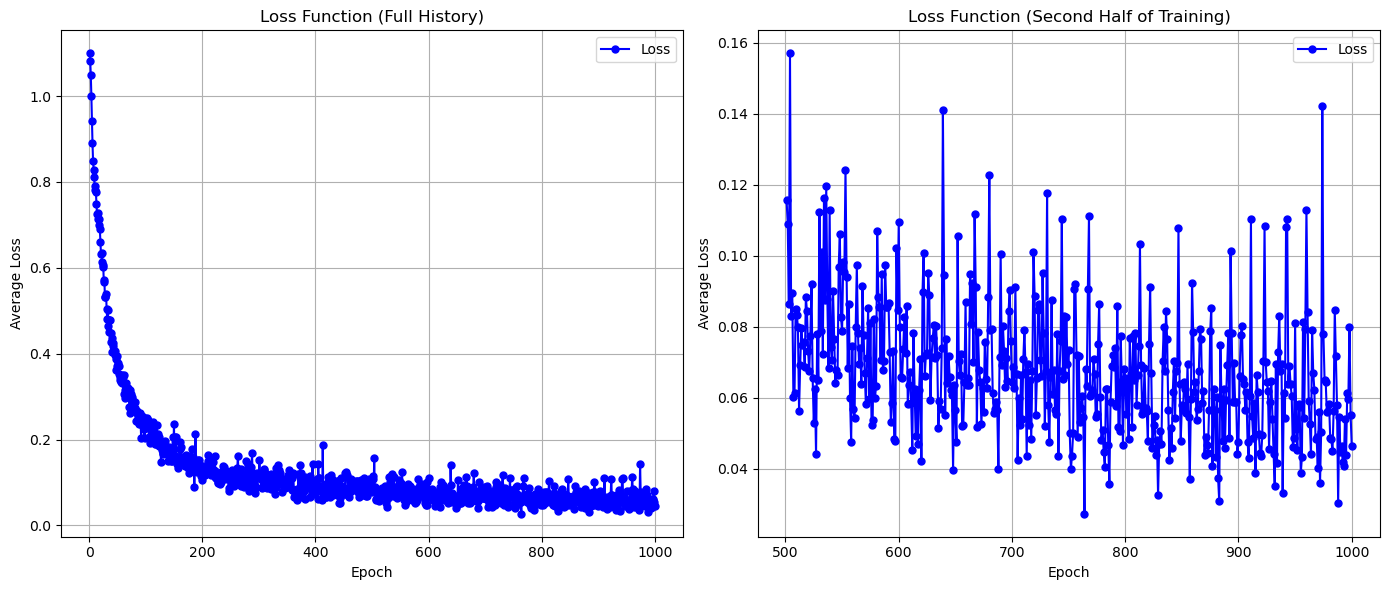

In [68]:
trainer5.plot_training_history()

#### Оценка

In [69]:
trainer5.evaluate(cifar100_005)

Classification report for train dataset:
              precision    recall  f1-score   support

    wardrobe     1.0000    1.0000    1.0000       500
  chimpanzee     0.9980    1.0000    0.9990       500
    mushroom     1.0000    0.9980    0.9990       500

    accuracy                         0.9993      1500
   macro avg     0.9993    0.9993    0.9993      1500
weighted avg     0.9993    0.9993    0.9993      1500

--------------------------------------------------
Classification report for test dataset:
              precision    recall  f1-score   support

    wardrobe     0.8100    0.8100    0.8100       100
  chimpanzee     0.8500    0.6800    0.7556       100
    mushroom     0.7167    0.8600    0.7818       100

    accuracy                         0.7833       300
   macro avg     0.7922    0.7833    0.7825       300
weighted avg     0.7922    0.7833    0.7825       300

--------------------------------------------------


#### Сохранение модели в ONNX

In [70]:
trainer5.save_model(cifar100_005)

Model saved as: cifar100_5562c28e-55cd-40f6-bfad-ca88085b6da4.onnx
Model UUID: 5562c28e-55cd-40f6-bfad-ca88085b6da4
